In [1]:
import csv
import numpy as np 
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt 
import pickle
import statistics
import numpy as np  
import sys

pd.set_option('display.max_rows', 4000)
pd.set_option('display.max_columns', 200)

In [2]:
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

**Sentiment Analysis provided by Upasana - Tweets need to be cleaned prior to using.**


In [4]:
def sentiment_analyzer_score_for_englishOnlyTweet(cleaned_tweet): #this function takes in a tweet that has been detected as an english tweet
    score = analyser.polarity_scores(cleaned_tweet) #so this cleaned_tweet is always an english tweet.
    lb = score['compound']
    return lb

**Read in list of users to analyze**

In [5]:
df = pd.read_csv('Filtered_EnglishUsers_MentionBackedUsers.csv')
# df = pd.read_csv('Filtered_EnglishUsers_DidnotMentionBackUsers.csv')
UserList = list(df['Users'])

In [6]:
print(UserList[0])
len(UserList)

Gypsy7714


623

In [7]:
iraContactPoints = pd.read_csv('contact_IRAtoUser.csv')
# iraContactPoints.head()

**Create dict of contact points, formatted: username -> [list of contact points]**

In [8]:
iraContactDict = {}
for i in range(len(iraContactPoints)):
    
    temp_list = iraContactPoints['tweet_date'][i].split(', ')
    temp_list[0] = temp_list[0][1:]
    temp_list[-1] = temp_list[-1][:-1]
    for j in range(len(temp_list)):
        temp_list[j] = temp_list[j][1:]
        temp_list[j] = temp_list[j][:-1]
#     temp_list.sort()
    iraContactDict[iraContactPoints['username'][i]] = temp_list


In [9]:
for key in iraContactDict:
    temp_list = iraContactDict[key]
    temp_list.sort()


In [10]:
# for key in iraContactDict:
#     print(key)
#     print(iraContactDict[key])
#     print("\n\n")

**Functions to check for a mention of Donald Trump or Hillary Clinton in a tweet**


In [11]:
def mentions_trump(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'realdonaldtrump':
                return True
    return False

In [12]:
def mentions_clinton(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'hillaryclinton':
                return True
    return False

**Create new DataFrame, which will hold all before / after analysis date in the form of lists**

In [13]:
beforeAfterDF = pd.DataFrame(columns=['username', 'first_contact', 'second_contact',
                                      'third_contact','tweet_count','sentiment_scores', 
                                      'trump_count', 'clinton_count','trump_sent','clinton_sent'])

In [14]:
befAftCounts = pd.DataFrame(columns=['username', 'before_tweetcount1', 'before_tweetcount2', 'before_tweetcount3',
                                    'after_tweetcount1', 'after_tweetcount2', 'after_tweetcount3',
                                    'before_trumpcount1', 'before_trumpcount2', 'before_trumpcount3',
                                    'after_trumpcount1', 'after_trumpcount2', 'after_trumpcount3',
                                    'before_clintoncount1', 'before_clintoncount2', 'before_clintoncount3',
                                    'after_clintoncount1', 'after_clintoncount2', 'after_clintoncount3',
                                    'before_sentiment1', 'before_sentiment2', 'before_sentiment3',
                                    'after_sentiment1', 'after_sentiment2', 'after_sentiment3',
                                    'before_trump_sent1', 'before_trump_sent2', 'before_trump_sent3',
                                    'after_trump_sent1', 'after_trump_sent2', 'after_trump_sent3',
                                    'before_clinton_sent1', 'before_clinton_sent2', 'before_clinton_sent3',
                                    'after_clinton_sent1', 'after_clinton_sent2', 'after_clinton_sent3'
                                    ])

In [15]:
first_tweet_dict = {}
size = str(len(UserList))
for i in range(len(UserList)):
# for i in range(10):
    try:
        #create temp DF
        temp_user_db = pd.read_csv('/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'+UserList[i]+'.csv', header=None, low_memory=False)
        #save first tweet date
        first_tweet_date = temp_user_db[3][len(temp_user_db)-1]
        first_tweet_dict[UserList[i]] = first_tweet_date
        #initialize values
        tweet_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        trump_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        clinton_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        sentiment_scores = [
            [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
        trump_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
        clinton_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
        
        username = UserList[i]
        contact_list = iraContactDict[username]
        first_contact = contact_list[0][:-6]
        first_contact = dt.strptime(first_contact, "%Y-%m-%d")
        second_contact = None
        third_contact = None
        if(len(contact_list) >= 2):
            second_contact = contact_list[1][:-6]
            second_contact = dt.strptime(second_contact, "%Y-%m-%d")
        if(len(contact_list) >= 3):
            third_contact = contact_list[2][:-6]
            third_contact = dt.strptime(third_contact, "%Y-%m-%d")
        #iterate through all tweets
        for j in range(len(temp_user_db)):
            #year one check
            current_date = temp_user_db[3][j]
            current_date = dt.strptime(current_date, "%Y-%m-%d")
            difference = ((((current_date - first_contact).total_seconds())/60)/60)/24
            if(difference >= -372 and difference <= 372):
                temp_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
                trump_flag = mentions_trump(str(temp_user_db[11][j]))
                clinton_flag = mentions_clinton(str(temp_user_db[11][j]))
                if(difference < 0):
                    if (difference <= -341 and difference > -372): #-12
                        tweet_count[0] +=1
                        if trump_flag: trump_count[0] += 1
                        if clinton_flag: clinton_count[0] += 1
                        sentiment_scores[0].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[0].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[0].append(temp_sent)
                    elif (difference <= -310 and difference > -341): #-11
                        tweet_count[1] +=1
                        if trump_flag: trump_count[1] += 1
                        if clinton_flag: clinton_count[1] += 1
                        sentiment_scores[1].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[1].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[1].append(temp_sent)
                    elif (difference <= -279 and difference > -310): #-10
                        tweet_count[2] +=1
                        if trump_flag: trump_count[2] += 1
                        if clinton_flag: clinton_count[2] += 1
                        sentiment_scores[2].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[2].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[2].append(temp_sent)
                    elif (difference <= -248 and difference > -279): #-9
                        tweet_count[3] +=1
                        if trump_flag: trump_count[3] += 1
                        if clinton_flag: clinton_count[3] += 1
                        sentiment_scores[3].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[3].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[3].append(temp_sent)
                    elif (difference <= -217 and difference > -248): #-8
                        tweet_count[4] +=1
                        if trump_flag: trump_count[4] += 1
                        if clinton_flag: clinton_count[4] += 1
                        sentiment_scores[4].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[4].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[4].append(temp_sent)
                    elif (difference <= -186 and difference > -217): #-7
                        tweet_count[5] +=1
                        if trump_flag: trump_count[5] += 1
                        if clinton_flag: clinton_count[5] += 1
                        sentiment_scores[5].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[5].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[5].append(temp_sent)
                    elif (difference <= -155 and difference > -186): #-6
                        tweet_count[6] +=1
                        if trump_flag: trump_count[6] += 1
                        if clinton_flag: clinton_count[6] += 1
                        sentiment_scores[6].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[6].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[6].append(temp_sent)
                    elif (difference <= -124 and difference > -155): #-5
                        tweet_count[7] +=1
                        if trump_flag: trump_count[7] += 1
                        if clinton_flag: clinton_count[7] += 1
                        sentiment_scores[7].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[7].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[7].append(temp_sent)
                    elif (difference <= -93 and difference > -124): #-4
                        tweet_count[8] +=1
                        if trump_flag: trump_count[8] += 1
                        if clinton_flag: clinton_count[8] += 1
                        sentiment_scores[8].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[8].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[8].append(temp_sent)
                    elif (difference <= -62 and difference > -93): #-3
                        tweet_count[9] +=1
                        if trump_flag: trump_count[9] += 1
                        if clinton_flag: clinton_count[9] += 1
                        sentiment_scores[9].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[9].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[9].append(temp_sent)
                    elif (difference <= -31 and difference > -62): #-2
                        tweet_count[10] +=1
                        if trump_flag: trump_count[10] += 1
                        if clinton_flag: clinton_count[10] += 1
                        sentiment_scores[10].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[10].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[10].append(temp_sent)
                    elif (difference <= 0 and difference > -31): #-1
                        tweet_count[11] +=1
                        if trump_flag: trump_count[11] += 1
                        if clinton_flag: clinton_count[11] += 1
                        sentiment_scores[11].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[11].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[11].append(temp_sent)
                if(difference >= 0):
                    if (difference >= 0 and difference < 31): #1 
                        tweet_count[12] +=1
                        if trump_flag: trump_count[12] += 1
                        if clinton_flag: clinton_count[12] += 1
                        sentiment_scores[12].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[12].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[12].append(temp_sent)
                    elif (difference >= 31 and difference < 62): #2 
                        tweet_count[13] +=1
                        if trump_flag: trump_count[13] += 1
                        if clinton_flag: clinton_count[13] += 1
                        sentiment_scores[13].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[13].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[13].append(temp_sent)
                    elif (difference >= 62 and difference < 93): #3
                        tweet_count[14] +=1
                        if trump_flag: trump_count[14] += 1
                        if clinton_flag: clinton_count[14] += 1
                        sentiment_scores[14].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[14].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[14].append(temp_sent)
                    elif (difference >= 93 and difference < 124): #4
                        tweet_count[15] +=1
                        if trump_flag: trump_count[15] += 1
                        if clinton_flag: clinton_count[15] += 1
                        sentiment_scores[15].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[15].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[15].append(temp_sent)
                    elif (difference >= 124 and difference < 155): #5
                        tweet_count[16] +=1
                        if trump_flag: trump_count[16] += 1
                        if clinton_flag: clinton_count[16] += 1
                        sentiment_scores[16].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[16].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[16].append(temp_sent)
                    elif (difference >= 155 and difference < 186): #6
                        tweet_count[17] +=1
                        if trump_flag: trump_count[17] += 1
                        if clinton_flag: clinton_count[17] += 1
                        sentiment_scores[17].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[17].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[17].append(temp_sent)
                    elif (difference >= 186 and difference < 217): #7
                        tweet_count[18] +=1
                        if trump_flag: trump_count[18] += 1
                        if clinton_flag: clinton_count[18] += 1
                        sentiment_scores[18].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[18].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[18].append(temp_sent)
                    elif (difference >= 217 and difference < 248): #8
                        tweet_count[19] += 1
                        if trump_flag: trump_count[19] += 1
                        if clinton_flag: clinton_count[19] += 1
                        sentiment_scores[19].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[19].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[19].append(temp_sent)
                    elif (difference >= 248 and difference < 279): #9
                        tweet_count[20] +=1
                        if trump_flag: trump_count[20] += 1
                        if clinton_flag: clinton_count[20] += 1
                        sentiment_scores[20].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[20].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[20].append(temp_sent)
                    elif (difference >= 279 and difference < 310): #10
                        tweet_count[21] +=1
                        if trump_flag: trump_count[21] += 1
                        if clinton_flag: clinton_count[21] += 1
                        sentiment_scores[21].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[21].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[21].append(temp_sent)
                    elif (difference >= 310 and difference < 341): #11 
                        tweet_count[22] +=1
                        if trump_flag: trump_count[22] += 1
                        if clinton_flag: clinton_count[22] += 1
                        sentiment_scores[22].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[22].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[22].append(temp_sent)
                    elif (difference >= 341 and difference < 372): #12  
                        tweet_count[23] +=1
                        if trump_flag: trump_count[23] += 1
                        if clinton_flag: clinton_count[23] += 1
                        sentiment_scores[23].append(temp_sent)
                        if trump_flag and not clinton_flag: trump_sent[23].append(temp_sent)
                        if clinton_flag and not trump_flag: clinton_sent[23].append(temp_sent)
            #year two check
            if(second_contact != None):
                difference = ((((current_date - second_contact).total_seconds())/60)/60)/24
                trump_flag = mentions_trump(str(temp_user_db[11][j]))
                clinton_flag = mentions_clinton(str(temp_user_db[11][j]))
                if(difference >= -372 and difference <= 372):
                    temp_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
                    if(difference < 0):
                        if (difference <= -341 and difference > -372): #-12
                            tweet_count[24] +=1
                            if trump_flag: trump_count[24] += 1
                            if clinton_flag: clinton_count[24] += 1
                            sentiment_scores[24].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[24].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[24].append(temp_sent)
                        elif (difference <= -310 and difference > -341): #-11
                            tweet_count[25] +=1
                            if trump_flag: trump_count[25] += 1
                            if clinton_flag: clinton_count[25] += 1
                            sentiment_scores[25].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[25].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[25].append(temp_sent)
                        elif (difference <= -279 and difference > -310): #-10
                            tweet_count[26] +=1
                            if trump_flag: trump_count[26] += 1
                            if clinton_flag: clinton_count[26] += 1
                            sentiment_scores[26].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[26].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[26].append(temp_sent)
                        elif (difference <= -248 and difference > -279): #-9
                            tweet_count[27] +=1
                            if trump_flag: trump_count[27] += 1
                            if clinton_flag: clinton_count[27] += 1
                            sentiment_scores[27].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[27].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[27].append(temp_sent)
                        elif (difference <= -217 and difference > -248): #-8
                            tweet_count[28] +=1
                            if trump_flag: trump_count[28] += 1
                            if clinton_flag: clinton_count[28] += 1
                            sentiment_scores[28].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[28].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[28].append(temp_sent)
                        elif (difference <= -186 and difference > -217): #-7
                            tweet_count[29] +=1
                            if trump_flag: trump_count[29] += 1
                            if clinton_flag: clinton_count[29] += 1
                            sentiment_scores[29].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[29].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[29].append(temp_sent)
                        elif (difference <= -155 and difference > -186): #-6
                            tweet_count[30] +=1
                            if trump_flag: trump_count[30] += 1
                            if clinton_flag: clinton_count[30] += 1
                            sentiment_scores[30].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[30].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[30].append(temp_sent)
                        elif (difference <= -124 and difference > -155): #-5
                            tweet_count[31] +=1
                            if trump_flag: trump_count[31] += 1
                            if clinton_flag: clinton_count[31] += 1
                            sentiment_scores[31].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[31].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[31].append(temp_sent)
                        elif (difference <= -93 and difference > -124): #-4
                            tweet_count[32] +=1
                            if trump_flag: trump_count[32] += 1
                            if clinton_flag: clinton_count[32] += 1
                            sentiment_scores[32].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[32].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[32].append(temp_sent)
                        elif (difference <= -62 and difference > -93): #-3
                            tweet_count[33] +=1
                            if trump_flag: trump_count[33] += 1
                            if clinton_flag: clinton_count[33] += 1
                            sentiment_scores[33].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[33].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[33].append(temp_sent)
                        elif (difference <= -31 and difference > -62): #-2
                            tweet_count[34] +=1
                            if trump_flag: trump_count[34] += 1
                            if clinton_flag: clinton_count[34] += 1
                            sentiment_scores[34].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[34].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[34].append(temp_sent)
                        elif (difference <= 0 and difference > -31): #-1
                            tweet_count[35] +=1
                            if trump_flag: trump_count[35] += 1
                            if clinton_flag: clinton_count[35] += 1
                            sentiment_scores[35].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[35].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[35].append(temp_sent)
                    if(difference >= 0):
                        if (difference >= 0 and difference < 31): #1 
                            tweet_count[36] +=1
                            if trump_flag: trump_count[36] += 1
                            if clinton_flag: clinton_count[36] += 1
                            sentiment_scores[36].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[36].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[36].append(temp_sent)
                        elif (difference >= 31 and difference < 62): #2 
                            tweet_count[37] +=1
                            if trump_flag: trump_count[37] += 1
                            if clinton_flag: clinton_count[37] += 1
                            sentiment_scores[37].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[37].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[37].append(temp_sent)
                        elif (difference >= 62 and difference < 93): #3
                            tweet_count[38] +=1
                            if trump_flag: trump_count[38] += 1
                            if clinton_flag: clinton_count[38] += 1
                            sentiment_scores[38].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[38].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[38].append(temp_sent)
                        elif (difference >= 93 and difference < 124): #4
                            tweet_count[39] +=1
                            if trump_flag: trump_count[39] += 1
                            if clinton_flag: clinton_count[39] += 1
                            sentiment_scores[39].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[39].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[39].append(temp_sent)
                        elif (difference >= 124 and difference < 155): #5
                            tweet_count[40] +=1
                            if trump_flag: trump_count[40] += 1
                            if clinton_flag: clinton_count[40] += 1
                            sentiment_scores[40].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[40].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[40].append(temp_sent)
                        elif (difference >= 155 and difference < 186): #6
                            tweet_count[41] +=1
                            if trump_flag: trump_count[41] += 1
                            if clinton_flag: clinton_count[41] += 1
                            sentiment_scores[41].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[41].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[41].append(temp_sent)
                        elif (difference >= 186 and difference < 217): #7
                            tweet_count[42] +=1
                            if trump_flag: trump_count[42] += 1
                            if clinton_flag: clinton_count[42] += 1
                            sentiment_scores[42].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[42].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[42].append(temp_sent)
                        elif (difference >= 217 and difference < 248): #8
                            tweet_count[43] += 1
                            if trump_flag: trump_count[43] += 1
                            if clinton_flag: clinton_count[43] += 1
                            sentiment_scores[43].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[43].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[43].append(temp_sent)
                        elif (difference >= 248 and difference < 279): #9
                            tweet_count[44] +=1
                            if trump_flag: trump_count[44] += 1
                            if clinton_flag: clinton_count[44] += 1
                            sentiment_scores[44].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[44].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[44].append(temp_sent)
                        elif (difference >= 279 and difference < 310): #10
                            tweet_count[45] +=1
                            if trump_flag: trump_count[45] += 1
                            if clinton_flag: clinton_count[45] += 1
                            sentiment_scores[45].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[45].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[45].append(temp_sent)
                        elif (difference >= 310 and difference < 341): #11 
                            tweet_count[46] +=1
                            if trump_flag: trump_count[46] += 1
                            if clinton_flag: clinton_count[46] += 1
                            sentiment_scores[46].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[46].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[46].append(temp_sent)
                        elif (difference >= 341 and difference < 372): #12  
                            tweet_count[47] +=1
                            if trump_flag: trump_count[47] += 1
                            if clinton_flag: clinton_count[47] += 1
                            sentiment_scores[47].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[47].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[47].append(temp_sent)
            #year three check
            if(third_contact != None):
                difference = ((((current_date - third_contact).total_seconds())/60)/60)/24
                if(difference >= -372 and difference <= 372):
                    temp_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
                    trump_flag = mentions_trump(str(temp_user_db[11][j]))
                    clinton_flag = mentions_clinton(str(temp_user_db[11][j]))
                    if(difference < 0):
                        if (difference <= -341 and difference > -372): #-12
                            tweet_count[48] +=1
                            if trump_flag: trump_count[48] += 1
                            if clinton_flag: clinton_count[48] += 1
                            sentiment_scores[48].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[48].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[48].append(temp_sent)
                        elif (difference <= -310 and difference > -341): #-11
                            tweet_count[49] +=1
                            if trump_flag: trump_count[49] += 1
                            if clinton_flag: clinton_count[49] += 1
                            sentiment_scores[49].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[49].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[49].append(temp_sent)
                        elif (difference <= -279 and difference > -310): #-10
                            tweet_count[50] +=1
                            if trump_flag: trump_count[50] += 1
                            if clinton_flag: clinton_count[50] += 1
                            sentiment_scores[50].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[50].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[50].append(temp_sent)
                        elif (difference <= -248 and difference > -279): #-9
                            tweet_count[51] +=1
                            if trump_flag: trump_count[51] += 1
                            if clinton_flag: clinton_count[51] += 1
                            sentiment_scores[51].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[51].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[51].append(temp_sent)
                        elif (difference <= -217 and difference > -248): #-8
                            tweet_count[52] +=1
                            if trump_flag: trump_count[52] += 1
                            if clinton_flag: clinton_count[52] += 1
                            sentiment_scores[52].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[52].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[52].append(temp_sent)
                        elif (difference <= -186 and difference > -217): #-7
                            tweet_count[53] +=1
                            if trump_flag: trump_count[53] += 1
                            if clinton_flag: clinton_count[53] += 1
                            sentiment_scores[53].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[53].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[53].append(temp_sent)
                        elif (difference <= -155 and difference > -186): #-6
                            tweet_count[54] +=1
                            if trump_flag: trump_count[54] += 1
                            if clinton_flag: clinton_count[54] += 1
                            sentiment_scores[54].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[54].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[54].append(temp_sent)
                        elif (difference <= -124 and difference > -155): #-5
                            tweet_count[55] +=1
                            if trump_flag: trump_count[55] += 1
                            if clinton_flag: clinton_count[55] += 1
                            sentiment_scores[55].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[55].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[55].append(temp_sent)
                        elif (difference <= -93 and difference > -124): #-4
                            tweet_count[56] +=1
                            if trump_flag: trump_count[56] += 1
                            if clinton_flag: clinton_count[56] += 1
                            sentiment_scores[56].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[56].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[56].append(temp_sent)
                        elif (difference <= -62 and difference > -93): #-3
                            tweet_count[57] +=1
                            if trump_flag: trump_count[57] += 1
                            if clinton_flag: clinton_count[57] += 1
                            sentiment_scores[57].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[57].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[57].append(temp_sent)
                        elif (difference <= -31 and difference > -62): #-2
                            tweet_count[58] +=1
                            if trump_flag: trump_count[58] += 1
                            if clinton_flag: clinton_count[58] += 1
                            sentiment_scores[58].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[58].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[58].append(temp_sent)
                        elif (difference < 0 and difference > -31): #-1
                            tweet_count[59] +=1
                            if trump_flag: trump_count[59] += 1
                            if clinton_flag: clinton_count[59] += 1
                            sentiment_scores[59].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[59].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[59].append(temp_sent)
                    if(difference >= 0):
                        if (difference >= 0 and difference < 31): #1 
                            tweet_count[60] +=1
                            if trump_flag: trump_count[60] += 1
                            if clinton_flag: clinton_count[60] += 1
                            sentiment_scores[60].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[60].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[60].append(temp_sent)
                        elif (difference >= 31 and difference < 62): #2 
                            tweet_count[61] +=1
                            if trump_flag: trump_count[61] += 1
                            if clinton_flag: clinton_count[61] += 1
                            sentiment_scores[61].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[61].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[61].append(temp_sent)
                        elif (difference >= 62 and difference < 93): #3
                            tweet_count[62] +=1
                            if trump_flag: trump_count[62] += 1
                            if clinton_flag: clinton_count[62] += 1
                            sentiment_scores[62].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[62].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[62].append(temp_sent)
                        elif (difference >= 93 and difference < 124): #4
                            tweet_count[63] +=1
                            if trump_flag: trump_count[63] += 1
                            if clinton_flag: clinton_count[63] += 1
                            sentiment_scores[63].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[63].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[63].append(temp_sent)
                        elif (difference >= 124 and difference < 155): #5
                            tweet_count[64] +=1
                            if trump_flag: trump_count[64] += 1
                            if clinton_flag: clinton_count[64] += 1
                            sentiment_scores[64].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[64].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[64].append(temp_sent)
                        elif (difference >= 155 and difference < 186): #6
                            tweet_count[65] +=1
                            if trump_flag: trump_count[65] += 1
                            if clinton_flag: clinton_count[65] += 1
                            sentiment_scores[65].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[65].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[65].append(temp_sent)
                        elif (difference >= 186 and difference < 217): #7
                            tweet_count[66] +=1
                            if trump_flag: trump_count[66] += 1
                            if clinton_flag: clinton_count[66] += 1
                            sentiment_scores[66].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[66].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[66].append(temp_sent)
                        elif (difference >= 217 and difference < 248): #8
                            tweet_count[67] += 1
                            if trump_flag: trump_count[67] += 1
                            if clinton_flag: clinton_count[67] += 1
                            sentiment_scores[67].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[67].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[67].append(temp_sent)
                        elif (difference >= 248 and difference < 279): #9
                            tweet_count[68] +=1
                            if trump_flag: trump_count[68] += 1
                            if clinton_flag: clinton_count[68] += 1
                            sentiment_scores[68].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[68].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[68].append(temp_sent)
                        elif (difference >= 279 and difference < 310): #10
                            tweet_count[69] +=1
                            if trump_flag: trump_count[69] += 1
                            if clinton_flag: clinton_count[69] += 1
                            sentiment_scores[69].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[69].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[69].append(temp_sent)
                        elif (difference >= 310 and difference < 341): #11 
                            tweet_count[70] +=1
                            if trump_flag: trump_count[70] += 1
                            if clinton_flag: clinton_count[70] += 1
                            sentiment_scores[70].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[70].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[70].append(temp_sent)
                        elif (difference >= 341 and difference < 372): #12  
                            tweet_count[71] +=1
                            if trump_flag: trump_count[71] += 1
                            if clinton_flag: clinton_count[71] += 1
                            sentiment_scores[71].append(temp_sent)
                            if trump_flag and not clinton_flag: trump_sent[71].append(temp_sent)
                            if clinton_flag and not trump_flag: clinton_sent[71].append(temp_sent)
        
        before_sentyear1 = []
        before_sentyear2 = []
        before_sentyear3 = []
        after_sentyear1 = []
        after_sentyear2 = []
        after_sentyear3 = []
        before_trump_sentyear1 = []
        before_trump_sentyear2 = []
        before_trump_sentyear3 = []
        after_trump_sentyear1 = []
        after_trump_sentyear2 = []
        after_trump_sentyear3 = []
        before_clinton_sentyear1 = []
        before_clinton_sentyear2 = []
        before_clinton_sentyear3 = []
        after_clinton_sentyear1 = []
        after_clinton_sentyear2 = []
        after_clinton_sentyear3 = []
        before_tweet1 = 0
        before_tweet2 = 0
        before_tweet3 = 0
        after_tweet1 = 0
        after_tweet2 = 0
        after_tweet3 = 0
        before_trump1 = 0
        before_trump2 = 0
        before_trump3 = 0
        after_trump1 = 0
        after_trump2 = 0
        after_trump3 = 0
        before_clinton1 = 0
        before_clinton2 = 0
        before_clinton3 = 0
        after_clinton1 = 0
        after_clinton2 = 0
        after_clinton3 = 0
        
        for q in range(9,12):
            before_tweet1 += tweet_count[q]
            before_trump1 += trump_count[q]
            before_clinton1 += clinton_count[q]
            if(len(sentiment_scores[q]) > 0):
                for j in range(len(sentiment_scores[q])):
                    before_sentyear1.append(sentiment_scores[q][j])
            if(len(trump_sent[q]) > 0):
                for j in range(len(trump_sent[q])):
                    before_trump_sentyear1.append(trump_sent[q][j])
            if(len(clinton_sent[q]) > 0):
                for j in range(len(clinton_sent[q])):
                    before_clinton_sentyear1.append(clinton_sent[q][j])
        for q in range(12,15):
            after_tweet1 += tweet_count[q]
            after_trump1 += trump_count[q]
            after_clinton1 += clinton_count[q]
            if(len(sentiment_scores[q]) > 0):
                for j in range(len(sentiment_scores[q])):
                    after_sentyear1.append(sentiment_scores[q][j])
            if(len(trump_sent[q]) > 0):
                for j in range(len(trump_sent[q])):
                    after_trump_sentyear1.append(trump_sent[q][j])
            if(len(clinton_sent[q]) > 0):
                for j in range(len(clinton_sent[q])):
                    after_clinton_sentyear1.append(clinton_sent[q][j])
        for q in range(33,36):
            before_tweet2 += tweet_count[q]
            before_trump2 += trump_count[q]
            before_clinton2 += clinton_count[q]
            if(len(sentiment_scores[q]) > 0):
                for j in range(len(sentiment_scores[q])):
                    before_sentyear2.append(sentiment_scores[q][j])
            if(len(trump_sent[q]) > 0):
                for j in range(len(trump_sent[q])):
                    before_trump_sentyear2.append(trump_sent[q][j])
            if(len(clinton_sent[q]) > 0):
                for j in range(len(clinton_sent[q])):
                    before_clinton_sentyear2.append(clinton_sent[q][j])
        for q in range(36,39):
            after_tweet2 += tweet_count[q]
            after_trump2 += trump_count[q]
            after_clinton2 += clinton_count[q]
            if(len(sentiment_scores[q]) > 0):
                for j in range(len(sentiment_scores[q])):
                    after_sentyear2.append(sentiment_scores[q][j])
            if(len(trump_sent[q]) > 0):
                for j in range(len(trump_sent[q])):
                    after_trump_sentyear2.append(trump_sent[q][j])
            if(len(clinton_sent[q]) > 0):
                for j in range(len(clinton_sent[q])):
                    after_clinton_sentyear2.append(clinton_sent[q][j])
        for q in range(57,60):
            before_tweet3 += tweet_count[q]
            before_trump3 += trump_count[q]
            before_clinton3 += clinton_count[q]
            if(len(sentiment_scores[q]) > 0):
                for j in range(len(sentiment_scores[q])):
                    before_sentyear3.append(sentiment_scores[q][j])
            if(len(trump_sent[q]) > 0):
                for j in range(len(trump_sent[q])):
                    before_trump_sentyear3.append(trump_sent[q][j])
            if(len(clinton_sent[q]) > 0):
                for j in range(len(clinton_sent[q])):
                    before_clinton_sentyear3.append(clinton_sent[q][j])
        for q in range(60,63):
            after_tweet3 += tweet_count[q]
            after_trump3 += trump_count[q]
            after_clinton3 += clinton_count[q]
            if(len(sentiment_scores[q]) > 0):
                for j in range(len(sentiment_scores[q])):
                    after_sentyear3.append(sentiment_scores[q][j])
            if(len(trump_sent[q]) > 0):
                for j in range(len(trump_sent[q])):
                    after_trump_sentyear3.append(trump_sent[q][j])
            if(len(clinton_sent[q]) > 0):
                for j in range(len(clinton_sent[q])):
                    after_clinton_sentyear3.append(clinton_sent[q][j])
            
            if(len(before_sentyear1)) == 0:
                before_sentyear1.append(0)
            if(len(before_sentyear2)) == 0:
                before_sentyear2.append(0)
            if(len(before_sentyear3)) == 0:
                before_sentyear3.append(0)
            if(len(after_sentyear1)) == 0:
                after_sentyear1.append(0)
            if(len(after_sentyear2)) == 0:
                after_sentyear2.append(0)
            if(len(after_sentyear3)) == 0:
                after_sentyear3.append(0)
            if(len(before_trump_sentyear1) == 0):
                before_trump_sentyear1.append(0)
            if(len(before_trump_sentyear2) == 0):
                before_trump_sentyear2.append(0)
            if(len(before_trump_sentyear3) == 0):
                before_trump_sentyear3.append(0)
            if(len(after_trump_sentyear1) == 0):
                after_trump_sentyear1.append(0)
            if(len(after_trump_sentyear2) == 0):
                after_trump_sentyear2.append(0)
            if(len(after_trump_sentyear3) == 0):
                after_trump_sentyear3.append(0)
            if(len(before_clinton_sentyear1) == 0):
                before_clinton_sentyear1.append(0)
            if(len(before_clinton_sentyear2) == 0):
                before_clinton_sentyear2.append(0)
            if(len(before_clinton_sentyear3) == 0):
                before_clinton_sentyear3.append(0)
            if(len(after_clinton_sentyear1) == 0):
                after_clinton_sentyear1.append(0)
            if(len(after_clinton_sentyear2) == 0):
                after_clinton_sentyear2.append(0)
            if(len(after_clinton_sentyear3) == 0):
                after_clinton_sentyear3.append(0)
        
        befAftCounts = befAftCounts.append({
            'username' : username, 
            'before_tweetcount1' : before_tweet1, 'before_tweetcount2' : before_tweet2, 'before_tweetcount3' : before_tweet3,
            'after_tweetcount1' : after_tweet1, 'after_tweetcount2' : after_tweet2, 'after_tweetcount3' : after_tweet3,
            'before_trumpcount1' : before_trump1, 'before_trumpcount2' : before_trump2, 'before_trumpcount3' : before_trump3,
            'after_trumpcount1' : after_trump1, 'after_trumpcount2' : after_trump2, 'after_trumpcount3' : after_trump3,
            'before_clintoncount1' : before_clinton1, 'before_clintoncount2' : before_clinton2, 'before_clintoncount3' : before_clinton3,
            'after_clintoncount1' : after_clinton1, 'after_clintoncount2' : after_clinton2, 'after_clintoncount3' : after_clinton3,
            'before_sentiment1' : statistics.mean(before_sentyear1), 
            'before_sentiment2' : statistics.mean(before_sentyear2), 
            'before_sentiment3' : statistics.mean(before_sentyear3),
            'after_sentiment1' : statistics.mean(after_sentyear1), 
            'after_sentiment2' : statistics.mean(after_sentyear2), 
            'after_sentiment3' : statistics.mean(after_sentyear3),
            'before_trump_sent1' : statistics.mean(before_trump_sentyear1), 
            'before_trump_sent2' : statistics.mean(before_trump_sentyear2), 
            'before_trump_sent3' : statistics.mean(before_trump_sentyear3),
            'after_trump_sent1' : statistics.mean(after_trump_sentyear1), 
            'after_trump_sent2' : statistics.mean(after_trump_sentyear2), 
            'after_trump_sent3' : statistics.mean(after_trump_sentyear3),
            'before_clinton_sent1' : statistics.mean(before_clinton_sentyear1), 
            'before_clinton_sent2' : statistics.mean(before_clinton_sentyear2), 
            'before_clinton_sent3' : statistics.mean(before_clinton_sentyear3),
            'after_clinton_sent1' : statistics.mean(after_clinton_sentyear1), 
            'after_clinton_sent2' : statistics.mean(after_clinton_sentyear2), 
            'after_clinton_sent3' : statistics.mean(after_clinton_sentyear3) }, ignore_index = True)
        
        for k in range(len(sentiment_scores)):
            if(len(sentiment_scores[k]) > 0 ):
                sentiment_scores[k] = statistics.mean(sentiment_scores[k])
            else:
                sentiment_scores[k] = 0
                
        for k in range(len(trump_sent)):
            if(len(trump_sent[k]) > 0 ):
                trump_sent[k] = statistics.mean(trump_sent[k])
            else:
                trump_sent[k] = 0
                
        for k in range(len(clinton_sent)):
            if(len(clinton_sent[k]) > 0 ):
                clinton_sent[k] = statistics.mean(clinton_sent[k])
            else:
                clinton_sent[k] = 0

        beforeAfterDF = beforeAfterDF.append({
            'username' : username, 'first_contact' : first_contact, 'second_contact' : second_contact,
            'third_contact' : third_contact, 'tweet_count' : tweet_count, 'sentiment_scores' : sentiment_scores,
            'trump_count' : trump_count, 'clinton_count' : clinton_count, 'trump_sent' : trump_sent, 
            'clinton_sent' : clinton_sent }, ignore_index = True) 
        
        print(str(i+1)+" / " + size)
    except Exception as e: 
        print(str(UserList[i]) + " failed - " + str(e))


1 / 623
2 / 623
3 / 623
4 / 623
5 / 623
6 / 623
7 / 623
8 / 623
9 / 623
10 / 623
11 / 623
12 / 623
13 / 623
14 / 623
15 / 623
16 / 623
17 / 623
18 / 623
19 / 623
20 / 623
21 / 623
22 / 623
23 / 623
24 / 623
25 / 623
26 / 623
27 / 623
28 / 623
29 / 623
30 / 623
31 / 623
32 / 623
33 / 623
34 / 623
35 / 623
36 / 623
37 / 623
38 / 623
39 / 623
40 / 623
41 / 623
42 / 623
43 / 623
44 / 623
45 / 623
46 / 623
47 / 623
48 / 623
49 / 623
50 / 623
51 / 623
52 / 623
53 / 623
54 / 623
55 / 623
56 / 623
57 / 623
58 / 623
59 / 623
60 / 623
61 / 623
62 / 623
63 / 623
64 / 623
65 / 623
66 / 623
67 / 623
68 / 623
69 / 623
70 / 623
71 / 623
72 / 623
73 / 623
74 / 623
75 / 623
76 / 623
77 / 623
78 / 623
79 / 623
80 / 623
81 / 623
82 / 623
83 / 623
84 / 623
85 / 623
86 / 623
87 / 623
88 / 623
89 / 623
90 / 623
91 / 623
92 / 623
93 / 623
94 / 623
95 / 623
96 / 623
97 / 623
98 / 623
99 / 623
100 / 623
101 / 623
102 / 623
103 / 623
104 / 623
105 / 623
106 / 623
107 / 623
108 / 623
109 / 623
110 / 623
111 / 62

In [16]:
befAftCounts.to_csv('beforeAfter_counts_responsive.csv')
befAftCounts.to_pickle('beforeAfter_counts_responsive.pkl')

In [17]:
# befAftCounts.head()

**Create dictionary of users first tweet dates**

Format: { [username] : str(date) }

In [18]:
# first_tweet_dict = {}

**Iterate through users and perform before / after analysis**

In [19]:
# size = str(len(UserList))
# for i in range(len(UserList)):
# # for i in range(10):
#     try:
#         #create temp DF
#         temp_user_db = pd.read_csv('/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'+UserList[i]+'.csv', header=None, low_memory=False)
#         #save first tweet date
#         first_tweet_date = temp_user_db[3][len(temp_user_db)-1]
#         first_tweet_dict[UserList[i]] = first_tweet_date
#         #initialize values
#         tweet_count = [
#             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
#             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
#             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#         trump_count = [
#             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
#             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
#             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#         clinton_count = [
#             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
#             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
#             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#         sentiment_scores = [
#             [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
#             [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
#             [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
#         trump_sent = [
#             [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
#             [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
#             [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
#         clinton_sent = [
#             [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
#             [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
#             [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]

#         username = UserList[i]
#         contact_list = iraContactDict[username]
#         first_contact = contact_list[0][:-6]
#         first_contact = dt.strptime(first_contact, "%Y-%m-%d")
#         second_contact = None
#         third_contact = None
#         if(len(contact_list) >= 2):
#             second_contact = contact_list[1][:-6]
#             second_contact = dt.strptime(second_contact, "%Y-%m-%d")
#         if(len(contact_list) >= 3):
#             third_contact = contact_list[2][:-6]
#             third_contact = dt.strptime(third_contact, "%Y-%m-%d")
#         #iterate through all tweets
#         for j in range(len(temp_user_db)):
#             #year one check
#             current_date = temp_user_db[3][j]
#             current_date = dt.strptime(current_date, "%Y-%m-%d")
#             difference = ((((current_date - first_contact).total_seconds())/60)/60)/24
#             if(difference >= -372 and difference <= 372):
#                 temp_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
#                 trump_flag = mentions_trump(str(temp_user_db[11][j]))
#                 clinton_flag = mentions_clinton(str(temp_user_db[11][j]))
#                 if(difference < 0):
#                     if (difference <= -341 and difference > -372): #-12
#                         tweet_count[0] +=1
#                         if trump_flag: trump_count[0] += 1
#                         if clinton_flag: clinton_count[0] += 1
#                         sentiment_scores[0].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[0].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[0].append(temp_sent)
#                     elif (difference <= -310 and difference > -341): #-11
#                         tweet_count[1] +=1
#                         if trump_flag: trump_count[1] += 1
#                         if clinton_flag: clinton_count[1] += 1
#                         sentiment_scores[1].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[1].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[1].append(temp_sent)
#                     elif (difference <= -279 and difference > -310): #-10
#                         tweet_count[2] +=1
#                         if trump_flag: trump_count[2] += 1
#                         if clinton_flag: clinton_count[2] += 1
#                         sentiment_scores[2].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[2].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[2].append(temp_sent)
#                     elif (difference <= -248 and difference > -279): #-9
#                         tweet_count[3] +=1
#                         if trump_flag: trump_count[3] += 1
#                         if clinton_flag: clinton_count[3] += 1
#                         sentiment_scores[3].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[3].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[3].append(temp_sent)
#                     elif (difference <= -217 and difference > -248): #-8
#                         tweet_count[4] +=1
#                         if trump_flag: trump_count[4] += 1
#                         if clinton_flag: clinton_count[4] += 1
#                         sentiment_scores[4].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[4].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[4].append(temp_sent)
#                     elif (difference <= -186 and difference > -217): #-7
#                         tweet_count[5] +=1
#                         if trump_flag: trump_count[5] += 1
#                         if clinton_flag: clinton_count[5] += 1
#                         sentiment_scores[5].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[5].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[5].append(temp_sent)
#                     elif (difference <= -155 and difference > -186): #-6
#                         tweet_count[6] +=1
#                         if trump_flag: trump_count[6] += 1
#                         if clinton_flag: clinton_count[6] += 1
#                         sentiment_scores[6].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[6].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[6].append(temp_sent)
#                     elif (difference <= -124 and difference > -155): #-5
#                         tweet_count[7] +=1
#                         if trump_flag: trump_count[7] += 1
#                         if clinton_flag: clinton_count[7] += 1
#                         sentiment_scores[7].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[7].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[7].append(temp_sent)
#                     elif (difference <= -93 and difference > -124): #-4
#                         tweet_count[8] +=1
#                         if trump_flag: trump_count[8] += 1
#                         if clinton_flag: clinton_count[8] += 1
#                         sentiment_scores[8].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[8].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[8].append(temp_sent)
#                     elif (difference <= -62 and difference > -93): #-3
#                         tweet_count[9] +=1
#                         if trump_flag: trump_count[9] += 1
#                         if clinton_flag: clinton_count[9] += 1
#                         sentiment_scores[9].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[9].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[9].append(temp_sent)
#                     elif (difference <= -31 and difference > -62): #-2
#                         tweet_count[10] +=1
#                         if trump_flag: trump_count[10] += 1
#                         if clinton_flag: clinton_count[10] += 1
#                         sentiment_scores[10].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[10].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[10].append(temp_sent)
#                     elif (difference <= 0 and difference > -31): #-1
#                         tweet_count[11] +=1
#                         if trump_flag: trump_count[11] += 1
#                         if clinton_flag: clinton_count[11] += 1
#                         sentiment_scores[11].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[11].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[11].append(temp_sent)
#                 if(difference >= 0):
#                     if (difference >= 0 and difference < 31): #1 
#                         tweet_count[12] +=1
#                         if trump_flag: trump_count[12] += 1
#                         if clinton_flag: clinton_count[12] += 1
#                         sentiment_scores[12].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[12].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[12].append(temp_sent)
#                     elif (difference >= 31 and difference < 62): #2 
#                         tweet_count[13] +=1
#                         if trump_flag: trump_count[13] += 1
#                         if clinton_flag: clinton_count[13] += 1
#                         sentiment_scores[13].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[13].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[13].append(temp_sent)
#                     elif (difference >= 62 and difference < 93): #3
#                         tweet_count[14] +=1
#                         if trump_flag: trump_count[14] += 1
#                         if clinton_flag: clinton_count[14] += 1
#                         sentiment_scores[14].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[14].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[14].append(temp_sent)
#                     elif (difference >= 93 and difference < 124): #4
#                         tweet_count[15] +=1
#                         if trump_flag: trump_count[15] += 1
#                         if clinton_flag: clinton_count[15] += 1
#                         sentiment_scores[15].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[15].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[15].append(temp_sent)
#                     elif (difference >= 124 and difference < 155): #5
#                         tweet_count[16] +=1
#                         if trump_flag: trump_count[16] += 1
#                         if clinton_flag: clinton_count[16] += 1
#                         sentiment_scores[16].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[16].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[16].append(temp_sent)
#                     elif (difference >= 155 and difference < 186): #6
#                         tweet_count[17] +=1
#                         if trump_flag: trump_count[17] += 1
#                         if clinton_flag: clinton_count[17] += 1
#                         sentiment_scores[17].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[17].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[17].append(temp_sent)
#                     elif (difference >= 186 and difference < 217): #7
#                         tweet_count[18] +=1
#                         if trump_flag: trump_count[18] += 1
#                         if clinton_flag: clinton_count[18] += 1
#                         sentiment_scores[18].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[18].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[18].append(temp_sent)
#                     elif (difference >= 217 and difference < 248): #8
#                         tweet_count[19] += 1
#                         if trump_flag: trump_count[19] += 1
#                         if clinton_flag: clinton_count[19] += 1
#                         sentiment_scores[19].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[19].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[19].append(temp_sent)
#                     elif (difference >= 248 and difference < 279): #9
#                         tweet_count[20] +=1
#                         if trump_flag: trump_count[20] += 1
#                         if clinton_flag: clinton_count[20] += 1
#                         sentiment_scores[20].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[20].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[20].append(temp_sent)
#                     elif (difference >= 279 and difference < 310): #10
#                         tweet_count[21] +=1
#                         if trump_flag: trump_count[21] += 1
#                         if clinton_flag: clinton_count[21] += 1
#                         sentiment_scores[21].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[21].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[21].append(temp_sent)
#                     elif (difference >= 310 and difference < 341): #11 
#                         tweet_count[22] +=1
#                         if trump_flag: trump_count[22] += 1
#                         if clinton_flag: clinton_count[22] += 1
#                         sentiment_scores[22].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[22].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[22].append(temp_sent)
#                     elif (difference >= 341 and difference < 372): #12  
#                         tweet_count[23] +=1
#                         if trump_flag: trump_count[23] += 1
#                         if clinton_flag: clinton_count[23] += 1
#                         sentiment_scores[23].append(temp_sent)
#                         if trump_flag and not clinton_flag: trump_sent[23].append(temp_sent)
#                         if clinton_flag and not trump_flag: clinton_sent[23].append(temp_sent)
#             #year two check
#             if(second_contact != None):
#                 difference = ((((current_date - second_contact).total_seconds())/60)/60)/24
#                 trump_flag = mentions_trump(str(temp_user_db[11][j]))
#                 clinton_flag = mentions_clinton(str(temp_user_db[11][j]))
#                 if(difference >= -372 and difference <= 372):
#                     temp_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
#                     if(difference < 0):
#                         if (difference <= -341 and difference > -372): #-12
#                             tweet_count[24] +=1
#                             if trump_flag: trump_count[24] += 1
#                             if clinton_flag: clinton_count[24] += 1
#                             sentiment_scores[24].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[24].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[24].append(temp_sent)
#                         elif (difference <= -310 and difference > -341): #-11
#                             tweet_count[25] +=1
#                             if trump_flag: trump_count[25] += 1
#                             if clinton_flag: clinton_count[25] += 1
#                             sentiment_scores[25].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[25].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[25].append(temp_sent)
#                         elif (difference <= -279 and difference > -310): #-10
#                             tweet_count[26] +=1
#                             if trump_flag: trump_count[26] += 1
#                             if clinton_flag: clinton_count[26] += 1
#                             sentiment_scores[26].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[26].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[26].append(temp_sent)
#                         elif (difference <= -248 and difference > -279): #-9
#                             tweet_count[27] +=1
#                             if trump_flag: trump_count[27] += 1
#                             if clinton_flag: clinton_count[27] += 1
#                             sentiment_scores[27].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[27].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[27].append(temp_sent)
#                         elif (difference <= -217 and difference > -248): #-8
#                             tweet_count[28] +=1
#                             if trump_flag: trump_count[28] += 1
#                             if clinton_flag: clinton_count[28] += 1
#                             sentiment_scores[28].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[28].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[28].append(temp_sent)
#                         elif (difference <= -186 and difference > -217): #-7
#                             tweet_count[29] +=1
#                             if trump_flag: trump_count[29] += 1
#                             if clinton_flag: clinton_count[29] += 1
#                             sentiment_scores[29].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[29].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[29].append(temp_sent)
#                         elif (difference <= -155 and difference > -186): #-6
#                             tweet_count[30] +=1
#                             if trump_flag: trump_count[30] += 1
#                             if clinton_flag: clinton_count[30] += 1
#                             sentiment_scores[30].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[30].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[30].append(temp_sent)
#                         elif (difference <= -124 and difference > -155): #-5
#                             tweet_count[31] +=1
#                             if trump_flag: trump_count[31] += 1
#                             if clinton_flag: clinton_count[31] += 1
#                             sentiment_scores[31].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[31].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[31].append(temp_sent)
#                         elif (difference <= -93 and difference > -124): #-4
#                             tweet_count[32] +=1
#                             if trump_flag: trump_count[32] += 1
#                             if clinton_flag: clinton_count[32] += 1
#                             sentiment_scores[32].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[32].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[32].append(temp_sent)
#                         elif (difference <= -62 and difference > -93): #-3
#                             tweet_count[33] +=1
#                             if trump_flag: trump_count[33] += 1
#                             if clinton_flag: clinton_count[33] += 1
#                             sentiment_scores[33].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[33].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[33].append(temp_sent)
#                         elif (difference <= -31 and difference > -62): #-2
#                             tweet_count[34] +=1
#                             if trump_flag: trump_count[34] += 1
#                             if clinton_flag: clinton_count[34] += 1
#                             sentiment_scores[34].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[34].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[34].append(temp_sent)
#                         elif (difference <= 0 and difference > -31): #-1
#                             tweet_count[35] +=1
#                             if trump_flag: trump_count[35] += 1
#                             if clinton_flag: clinton_count[35] += 1
#                             sentiment_scores[35].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[35].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[35].append(temp_sent)
#                     if(difference >= 0):
#                         if (difference >= 0 and difference < 31): #1 
#                             tweet_count[36] +=1
#                             if trump_flag: trump_count[36] += 1
#                             if clinton_flag: clinton_count[36] += 1
#                             sentiment_scores[36].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[36].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[36].append(temp_sent)
#                         elif (difference >= 31 and difference < 62): #2 
#                             tweet_count[37] +=1
#                             if trump_flag: trump_count[37] += 1
#                             if clinton_flag: clinton_count[37] += 1
#                             sentiment_scores[37].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[37].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[37].append(temp_sent)
#                         elif (difference >= 62 and difference < 93): #3
#                             tweet_count[38] +=1
#                             if trump_flag: trump_count[38] += 1
#                             if clinton_flag: clinton_count[38] += 1
#                             sentiment_scores[38].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[38].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[38].append(temp_sent)
#                         elif (difference >= 93 and difference < 124): #4
#                             tweet_count[39] +=1
#                             if trump_flag: trump_count[39] += 1
#                             if clinton_flag: clinton_count[39] += 1
#                             sentiment_scores[39].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[39].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[39].append(temp_sent)
#                         elif (difference >= 124 and difference < 155): #5
#                             tweet_count[40] +=1
#                             if trump_flag: trump_count[40] += 1
#                             if clinton_flag: clinton_count[40] += 1
#                             sentiment_scores[40].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[40].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[40].append(temp_sent)
#                         elif (difference >= 155 and difference < 186): #6
#                             tweet_count[41] +=1
#                             if trump_flag: trump_count[41] += 1
#                             if clinton_flag: clinton_count[41] += 1
#                             sentiment_scores[41].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[41].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[41].append(temp_sent)
#                         elif (difference >= 186 and difference < 217): #7
#                             tweet_count[42] +=1
#                             if trump_flag: trump_count[42] += 1
#                             if clinton_flag: clinton_count[42] += 1
#                             sentiment_scores[42].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[42].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[42].append(temp_sent)
#                         elif (difference >= 217 and difference < 248): #8
#                             tweet_count[43] += 1
#                             if trump_flag: trump_count[43] += 1
#                             if clinton_flag: clinton_count[43] += 1
#                             sentiment_scores[43].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[43].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[43].append(temp_sent)
#                         elif (difference >= 248 and difference < 279): #9
#                             tweet_count[44] +=1
#                             if trump_flag: trump_count[44] += 1
#                             if clinton_flag: clinton_count[44] += 1
#                             sentiment_scores[44].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[44].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[44].append(temp_sent)
#                         elif (difference >= 279 and difference < 310): #10
#                             tweet_count[45] +=1
#                             if trump_flag: trump_count[45] += 1
#                             if clinton_flag: clinton_count[45] += 1
#                             sentiment_scores[45].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[45].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[45].append(temp_sent)
#                         elif (difference >= 310 and difference < 341): #11 
#                             tweet_count[46] +=1
#                             if trump_flag: trump_count[46] += 1
#                             if clinton_flag: clinton_count[46] += 1
#                             sentiment_scores[46].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[46].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[46].append(temp_sent)
#                         elif (difference >= 341 and difference < 372): #12  
#                             tweet_count[47] +=1
#                             if trump_flag: trump_count[47] += 1
#                             if clinton_flag: clinton_count[47] += 1
#                             sentiment_scores[47].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[47].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[47].append(temp_sent)
#             #year three check
#             if(third_contact != None):
#                 difference = ((((current_date - third_contact).total_seconds())/60)/60)/24
#                 if(difference >= -372 and difference <= 372):
#                     temp_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
#                     trump_flag = mentions_trump(str(temp_user_db[11][j]))
#                     clinton_flag = mentions_clinton(str(temp_user_db[11][j]))
#                     if(difference < 0):
#                         if (difference <= -341 and difference > -372): #-12
#                             tweet_count[48] +=1
#                             if trump_flag: trump_count[48] += 1
#                             if clinton_flag: clinton_count[48] += 1
#                             sentiment_scores[48].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[48].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[48].append(temp_sent)
#                         elif (difference <= -310 and difference > -341): #-11
#                             tweet_count[49] +=1
#                             if trump_flag: trump_count[49] += 1
#                             if clinton_flag: clinton_count[49] += 1
#                             sentiment_scores[49].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[49].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[49].append(temp_sent)
#                         elif (difference <= -279 and difference > -310): #-10
#                             tweet_count[50] +=1
#                             if trump_flag: trump_count[50] += 1
#                             if clinton_flag: clinton_count[50] += 1
#                             sentiment_scores[50].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[50].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[50].append(temp_sent)
#                         elif (difference <= -248 and difference > -279): #-9
#                             tweet_count[51] +=1
#                             if trump_flag: trump_count[51] += 1
#                             if clinton_flag: clinton_count[51] += 1
#                             sentiment_scores[51].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[51].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[51].append(temp_sent)
#                         elif (difference <= -217 and difference > -248): #-8
#                             tweet_count[52] +=1
#                             if trump_flag: trump_count[52] += 1
#                             if clinton_flag: clinton_count[52] += 1
#                             sentiment_scores[52].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[52].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[52].append(temp_sent)
#                         elif (difference <= -186 and difference > -217): #-7
#                             tweet_count[53] +=1
#                             if trump_flag: trump_count[53] += 1
#                             if clinton_flag: clinton_count[53] += 1
#                             sentiment_scores[53].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[53].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[53].append(temp_sent)
#                         elif (difference <= -155 and difference > -186): #-6
#                             tweet_count[54] +=1
#                             if trump_flag: trump_count[54] += 1
#                             if clinton_flag: clinton_count[54] += 1
#                             sentiment_scores[54].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[54].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[54].append(temp_sent)
#                         elif (difference <= -124 and difference > -155): #-5
#                             tweet_count[55] +=1
#                             if trump_flag: trump_count[55] += 1
#                             if clinton_flag: clinton_count[55] += 1
#                             sentiment_scores[55].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[55].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[55].append(temp_sent)
#                         elif (difference <= -93 and difference > -124): #-4
#                             tweet_count[56] +=1
#                             if trump_flag: trump_count[56] += 1
#                             if clinton_flag: clinton_count[56] += 1
#                             sentiment_scores[56].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[56].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[56].append(temp_sent)
#                         elif (difference <= -62 and difference > -93): #-3
#                             tweet_count[57] +=1
#                             if trump_flag: trump_count[57] += 1
#                             if clinton_flag: clinton_count[57] += 1
#                             sentiment_scores[57].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[57].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[57].append(temp_sent)
#                         elif (difference <= -31 and difference > -62): #-2
#                             tweet_count[58] +=1
#                             if trump_flag: trump_count[58] += 1
#                             if clinton_flag: clinton_count[58] += 1
#                             sentiment_scores[58].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[58].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[58].append(temp_sent)
#                         elif (difference < 0 and difference > -31): #-1
#                             tweet_count[59] +=1
#                             if trump_flag: trump_count[59] += 1
#                             if clinton_flag: clinton_count[59] += 1
#                             sentiment_scores[59].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[59].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[59].append(temp_sent)
#                     if(difference >= 0):
#                         if (difference >= 0 and difference < 31): #1 
#                             tweet_count[60] +=1
#                             if trump_flag: trump_count[60] += 1
#                             if clinton_flag: clinton_count[60] += 1
#                             sentiment_scores[60].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[60].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[60].append(temp_sent)
#                         elif (difference >= 31 and difference < 62): #2 
#                             tweet_count[61] +=1
#                             if trump_flag: trump_count[61] += 1
#                             if clinton_flag: clinton_count[61] += 1
#                             sentiment_scores[61].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[61].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[61].append(temp_sent)
#                         elif (difference >= 62 and difference < 93): #3
#                             tweet_count[62] +=1
#                             if trump_flag: trump_count[62] += 1
#                             if clinton_flag: clinton_count[62] += 1
#                             sentiment_scores[62].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[62].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[62].append(temp_sent)
#                         elif (difference >= 93 and difference < 124): #4
#                             tweet_count[63] +=1
#                             if trump_flag: trump_count[63] += 1
#                             if clinton_flag: clinton_count[63] += 1
#                             sentiment_scores[63].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[63].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[63].append(temp_sent)
#                         elif (difference >= 124 and difference < 155): #5
#                             tweet_count[64] +=1
#                             if trump_flag: trump_count[64] += 1
#                             if clinton_flag: clinton_count[64] += 1
#                             sentiment_scores[64].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[64].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[64].append(temp_sent)
#                         elif (difference >= 155 and difference < 186): #6
#                             tweet_count[65] +=1
#                             if trump_flag: trump_count[65] += 1
#                             if clinton_flag: clinton_count[65] += 1
#                             sentiment_scores[65].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[65].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[65].append(temp_sent)
#                         elif (difference >= 186 and difference < 217): #7
#                             tweet_count[66] +=1
#                             if trump_flag: trump_count[66] += 1
#                             if clinton_flag: clinton_count[66] += 1
#                             sentiment_scores[66].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[66].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[66].append(temp_sent)
#                         elif (difference >= 217 and difference < 248): #8
#                             tweet_count[67] += 1
#                             if trump_flag: trump_count[67] += 1
#                             if clinton_flag: clinton_count[67] += 1
#                             sentiment_scores[67].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[67].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[67].append(temp_sent)
#                         elif (difference >= 248 and difference < 279): #9
#                             tweet_count[68] +=1
#                             if trump_flag: trump_count[68] += 1
#                             if clinton_flag: clinton_count[68] += 1
#                             sentiment_scores[68].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[68].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[68].append(temp_sent)
#                         elif (difference >= 279 and difference < 310): #10
#                             tweet_count[69] +=1
#                             if trump_flag: trump_count[69] += 1
#                             if clinton_flag: clinton_count[69] += 1
#                             sentiment_scores[69].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[69].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[69].append(temp_sent)
#                         elif (difference >= 310 and difference < 341): #11 
#                             tweet_count[70] +=1
#                             if trump_flag: trump_count[70] += 1
#                             if clinton_flag: clinton_count[70] += 1
#                             sentiment_scores[70].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[70].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[70].append(temp_sent)
#                         elif (difference >= 341 and difference < 372): #12  
#                             tweet_count[71] +=1
#                             if trump_flag: trump_count[71] += 1
#                             if clinton_flag: clinton_count[71] += 1
#                             sentiment_scores[71].append(temp_sent)
#                             if trump_flag and not clinton_flag: trump_sent[71].append(temp_sent)
#                             if clinton_flag and not trump_flag: clinton_sent[71].append(temp_sent)
        
#         for k in range(len(sentiment_scores)):
#             if(len(sentiment_scores[k]) > 0 ):
#                 sentiment_scores[k] = statistics.mean(sentiment_scores[k])
#             else:
#                 sentiment_scores[k] = 0
                
#         for k in range(len(trump_sent)):
#             if(len(trump_sent[k]) > 0 ):
#                 trump_sent[k] = statistics.mean(trump_sent[k])
#             else:
#                 trump_sent[k] = 0
                
#         for k in range(len(clinton_sent)):
#             if(len(clinton_sent[k]) > 0 ):
#                 clinton_sent[k] = statistics.mean(clinton_sent[k])
#             else:
#                 clinton_sent[k] = 0

#         beforeAfterDF = beforeAfterDF.append({
#             'username' : username, 'first_contact' : first_contact, 'second_contact' : second_contact,
#             'third_contact' : third_contact, 'tweet_count' : tweet_count, 'sentiment_scores' : sentiment_scores,
#             'trump_count' : trump_count, 'clinton_count' : clinton_count, 'trump_sent' : trump_sent, 
#             'clinton_sent' : clinton_sent }, ignore_index = True)                                   
#         print(str(i+1)+" / " + size)
#     except Exception as e: 
#         print(str(UserList[i]) + " failed - " + str(e))


**Save Data**

In [20]:
# beforeAfterDF.to_csv('beforeAfter_AllData_MentionBackedUsers.csv')
beforeAfterDF.to_csv('BefAft_V3_DidRespond/befAft_1D_4_11_20.csv')
beforeAfterDF.to_pickle('BefAft_V3_DidRespond/befAft_1D_4_11_20.pkl')
# original_df.to_pickle("./dummy.pkl")

In [21]:
beforeAfterDF.head()

,username,first_contact,second_contact,third_contact,tweet_count,sentiment_scores,trump_count,clinton_count,trump_sent,clinton_sent
0,Gypsy7714,2016-05-15,2016-05-15,2016-05-15 00:00:00,"[72, 152, 192, 161, 63, 63, 79, 83, 27, 38, 20...","[-0.20589444444444444, -0.02954736842105263, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,PoliticaLion,2015-08-30,2016-02-02,2016-11-15 00:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,thejenn999,2016-06-16,2017-04-08,None,"[449, 508, 430, 354, 508, 523, 315, 340, 513, ...","[-0.039634521158129175, -0.12608326771653544, ...","[2, 1, 1, 0, 0, 0, 0, 1, 0, 3, 3, 0, 7, 1, 2, ...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[-0.0386, -0.7953, -0.2808, 0, 0, 0, 0, -0.296...","[0, 0, 0, 0, 0.5106, 0, 0, 0.0, 0, 0, 0, 0, 0,..."
3,Romey999,2017-04-14,2017-11-20,2017-11-20 00:00:00,"[126, 160, 78, 116, 420, 406, 359, 329, 223, 1...","[0.07803095238095238, 0.035460625, 0.055623076...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 15, 27, 28, 3, 45,...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0.2204, 0, 0, 0, 0, 0, 0, 0, 0.12002666666...","[0, 0, 0, 0, 0, -0.3149, 0, 0, 0, 0, 0.3252, 0..."
4,rathernotsay,2016-01-13,2016-01-13,2017-03-27 00:00:00,"[0, 1, 8, 0, 0, 0, 19, 26, 43, 14, 371, 1172, ...","[0, 0.126, -0.3764875, 0, 0, 0, 0.1533, 0.0637...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 13, 8, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.11005, -0.096...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, -0.0727333333..."


**Now we need to break apart the dataframe in order to analyze each contact span + criteria separately**

**First we create new DataFrames to hold each span + criteria**

In [22]:
year1DF_count = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year2DF_count = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year3DF_count = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])

year1DF_sent = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year2DF_sent = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year3DF_sent = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])

year1DF_trump = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year2DF_trump = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year3DF_trump = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])

year1DF_clinton = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year2DF_clinton = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year3DF_clinton = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])

year1DF_trump_sent = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year2DF_trump_sent = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year3DF_trump_sent = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])

year1DF_clinton_sent = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year2DF_clinton_sent = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year3DF_clinton_sent = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])

**Secondly, we need to popualte the DataFrames accordingly**

In [23]:
for i in range(len(beforeAfterDF)):
    
        username = beforeAfterDF['username'][i]
        tweet_count = beforeAfterDF['tweet_count'][i]
        sentiment_score = beforeAfterDF['sentiment_scores'][i]
        trump_count = beforeAfterDF['trump_count'][i]
        clinton_count = beforeAfterDF['clinton_count'][i]
        trump_sent = beforeAfterDF['trump_sent'][i]
        clinton_sent = beforeAfterDF['clinton_sent'][i]
        
        year1_count = tweet_count[0:24]
        year1_sent = sentiment_score[0:24]
        year1_trump = trump_count[0:24]
        year1_clinton = clinton_count[0:24]
        year1_trump_sent = trump_sent[0:24]
        year1_clinton_sent = clinton_sent[0:24]
        
        year1DF_count = year1DF_count.append({'username':username, 'contact':beforeAfterDF['first_contact'][i],
                                              '-12':year1_count[0],'-11':year1_count[1],'-10':year1_count[2],'-9':year1_count[3],
                                              '-8':year1_count[4],'-7':year1_count[5], '-6':year1_count[6], '-5':year1_count[7], 
                                              '-4':year1_count[8], '-3':year1_count[9], '-2':year1_count[10], '-1':year1_count[11], 
                                              '1':year1_count[12], '2':year1_count[13], '3':year1_count[14], '4':year1_count[15],
                                              '5':year1_count[16], '6':year1_count[17], '7':year1_count[18], '8':year1_count[19], 
                                              '9':year1_count[20], '10':year1_count[21], '11':year1_count[22], '12':year1_count[23]}, 
                                             ignore_index = True) 
        year1DF_sent = year1DF_sent.append({'username':username, 'contact':beforeAfterDF['first_contact'][i],
                                              '-12':year1_sent[0],'-11':year1_sent[1],'-10':year1_sent[2],'-9':year1_sent[3],
                                              '-8':year1_sent[4],'-7':year1_sent[5], '-6':year1_sent[6], '-5':year1_sent[7], 
                                              '-4':year1_sent[8], '-3':year1_sent[9], '-2':year1_sent[10], '-1':year1_sent[11], 
                                              '1':year1_sent[12], '2':year1_sent[13], '3':year1_sent[14], '4':year1_sent[15],
                                              '5':year1_sent[16], '6':year1_sent[17], '7':year1_sent[18], '8':year1_sent[19], 
                                              '9':year1_sent[20], '10':year1_sent[21], '11':year1_sent[22], '12':year1_sent[23]}, 
                                             ignore_index = True) 
        year1DF_trump = year1DF_trump.append({'username':username, 'contact':beforeAfterDF['first_contact'][i],
                                              '-12':year1_trump[0],'-11':year1_trump[1],'-10':year1_trump[2],'-9':year1_trump[3],
                                              '-8':year1_trump[4],'-7':year1_trump[5], '-6':year1_trump[6], '-5':year1_trump[7], 
                                              '-4':year1_trump[8], '-3':year1_trump[9], '-2':year1_trump[10], '-1':year1_trump[11], 
                                              '1':year1_trump[12], '2':year1_trump[13], '3':year1_trump[14], '4':year1_trump[15],
                                              '5':year1_trump[16], '6':year1_trump[17], '7':year1_trump[18], '8':year1_trump[19], 
                                              '9':year1_trump[20], '10':year1_trump[21], '11':year1_trump[22], '12':year1_trump[23]}, 
                                             ignore_index = True) 
        year1DF_clinton = year1DF_clinton.append({'username':username, 'contact':beforeAfterDF['first_contact'][i],
                                              '-12':year1_clinton[0],'-11':year1_clinton[1],'-10':year1_clinton[2],'-9':year1_clinton[3],
                                              '-8':year1_clinton[4],'-7':year1_clinton[5], '-6':year1_clinton[6], '-5':year1_clinton[7], 
                                              '-4':year1_clinton[8], '-3':year1_clinton[9], '-2':year1_clinton[10], '-1':year1_clinton[11], 
                                              '1':year1_clinton[12], '2':year1_clinton[13], '3':year1_clinton[14], '4':year1_clinton[15],
                                              '5':year1_clinton[16], '6':year1_clinton[17], '7':year1_clinton[18], '8':year1_clinton[19], 
                                              '9':year1_clinton[20], '10':year1_clinton[21], '11':year1_clinton[22], '12':year1_clinton[23]}, 
                                             ignore_index = True) 
        year1DF_trump_sent = year1DF_trump_sent.append({'username':username, 'contact':beforeAfterDF['first_contact'][i],
                                              '-12':year1_trump_sent[0],'-11':year1_trump_sent[1],'-10':year1_trump_sent[2],'-9':year1_trump_sent[3],
                                              '-8':year1_trump_sent[4],'-7':year1_trump_sent[5], '-6':year1_trump_sent[6], '-5':year1_trump_sent[7], 
                                              '-4':year1_trump_sent[8], '-3':year1_trump_sent[9], '-2':year1_trump_sent[10], '-1':year1_trump_sent[11], 
                                              '1':year1_trump_sent[12], '2':year1_trump_sent[13], '3':year1_trump_sent[14], '4':year1_trump_sent[15],
                                              '5':year1_trump_sent[16], '6':year1_trump_sent[17], '7':year1_trump_sent[18], '8':year1_trump_sent[19], 
                                              '9':year1_trump_sent[20], '10':year1_trump_sent[21], '11':year1_trump_sent[22], '12':year1_trump_sent[23]}, 
                                             ignore_index = True)
        year1DF_clinton_sent = year1DF_clinton_sent.append({'username':username, 'contact':beforeAfterDF['first_contact'][i],
                                              '-12':year1_clinton_sent[0],'-11':year1_clinton_sent[1],'-10':year1_clinton_sent[2],'-9':year1_clinton_sent[3],
                                              '-8':year1_clinton_sent[4],'-7':year1_clinton_sent[5], '-6':year1_clinton_sent[6], '-5':year1_clinton_sent[7], 
                                              '-4':year1_clinton_sent[8], '-3':year1_clinton_sent[9], '-2':year1_clinton_sent[10], '-1':year1_clinton_sent[11], 
                                              '1':year1_clinton_sent[12], '2':year1_clinton_sent[13], '3':year1_clinton_sent[14], '4':year1_clinton_sent[15],
                                              '5':year1_clinton_sent[16], '6':year1_clinton_sent[17], '7':year1_clinton_sent[18], '8':year1_clinton_sent[19], 
                                              '9':year1_clinton_sent[20], '10':year1_clinton_sent[21], '11':year1_clinton_sent[22], '12':year1_clinton_sent[23]}, 
                                             ignore_index = True)
        
#         if (str(beforeAfterDF['second_contact'][i]) != 'NaT') and (str(beforeAfterDF['second_contact'][i]) != 'None'):
        if beforeAfterDF['second_contact'][i] != None:
            year2_count = tweet_count[24:48]
            year2_sent = sentiment_score[24:48]
            year2_trump = trump_count[24:48]
            year2_clinton = clinton_count[24:48]
            year2_trump_sent = trump_sent[24:48]
            year2_clinton_sent = clinton_sent[24:48]
            year2DF_count = year2DF_count.append({'username':username, 'contact':beforeAfterDF['second_contact'][i],
                                              '-12':year2_count[0],'-11':year2_count[1],'-10':year2_count[2],'-9':year2_count[3],
                                              '-8':year2_count[4],'-7':year2_count[5], '-6':year2_count[6], '-5':year2_count[7], 
                                              '-4':year2_count[8], '-3':year2_count[9], '-2':year2_count[10], '-1':year2_count[11], 
                                              '1':year2_count[12], '2':year2_count[13], '3':year2_count[14], '4':year2_count[15],
                                              '5':year2_count[16], '6':year2_count[17], '7':year2_count[18], '8':year2_count[19], 
                                              '9':year2_count[20], '10':year2_count[21], '11':year2_count[22], '12':year2_count[23]}, 
                                             ignore_index = True) 
            year2DF_sent = year2DF_sent.append({'username':username, 'contact':beforeAfterDF['second_contact'][i],
                                              '-12':year2_sent[0],'-11':year2_sent[1],'-10':year2_sent[2],'-9':year2_sent[3],
                                              '-8':year2_sent[4],'-7':year2_sent[5], '-6':year2_sent[6], '-5':year2_sent[7], 
                                              '-4':year2_sent[8], '-3':year2_sent[9], '-2':year2_sent[10], '-1':year2_sent[11], 
                                              '1':year2_sent[12], '2':year2_sent[13], '3':year2_sent[14], '4':year2_sent[15],
                                              '5':year2_sent[16], '6':year2_sent[17], '7':year2_sent[18], '8':year2_sent[19], 
                                              '9':year2_sent[20], '10':year2_sent[21], '11':year2_sent[22], '12':year2_sent[23]}, 
                                             ignore_index = True) 
            year2DF_trump = year2DF_trump.append({'username':username, 'contact':beforeAfterDF['second_contact'][i],
                                              '-12':year2_trump[0],'-11':year2_trump[1],'-10':year2_trump[2],'-9':year2_trump[3],
                                              '-8':year2_trump[4],'-7':year2_trump[5], '-6':year2_trump[6], '-5':year2_trump[7], 
                                              '-4':year2_trump[8], '-3':year2_trump[9], '-2':year2_trump[10], '-1':year2_trump[11], 
                                              '1':year2_trump[12], '2':year2_trump[13], '3':year2_trump[14], '4':year2_trump[15],
                                              '5':year2_trump[16], '6':year2_trump[17], '7':year2_trump[18], '8':year2_trump[19], 
                                              '9':year2_trump[20], '10':year2_trump[21], '11':year2_trump[22], '12':year2_trump[23]}, 
                                             ignore_index = True)
            year2DF_clinton = year2DF_clinton.append({'username':username, 'contact':beforeAfterDF['second_contact'][i],
                                              '-12':year2_clinton[0],'-11':year2_clinton[1],'-10':year2_clinton[2],'-9':year2_clinton[3],
                                              '-8':year2_clinton[4],'-7':year2_clinton[5], '-6':year2_clinton[6], '-5':year2_clinton[7], 
                                              '-4':year2_clinton[8], '-3':year2_clinton[9], '-2':year2_clinton[10], '-1':year2_clinton[11], 
                                              '1':year2_clinton[12], '2':year2_clinton[13], '3':year2_clinton[14], '4':year2_clinton[15],
                                              '5':year2_clinton[16], '6':year2_clinton[17], '7':year2_clinton[18], '8':year2_clinton[19], 
                                              '9':year2_clinton[20], '10':year2_clinton[21], '11':year2_clinton[22], '12':year2_clinton[23]}, 
                                             ignore_index = True)
            year2DF_trump_sent = year2DF_trump_sent.append({'username':username, 'contact':beforeAfterDF['first_contact'][i],
                                              '-12':year2_trump_sent[0],'-11':year2_trump_sent[1],'-10':year2_trump_sent[2],'-9':year2_trump_sent[3],
                                              '-8':year2_trump_sent[4],'-7':year2_trump_sent[5], '-6':year2_trump_sent[6], '-5':year2_trump_sent[7], 
                                              '-4':year2_trump_sent[8], '-3':year2_trump_sent[9], '-2':year2_trump_sent[10], '-1':year2_trump_sent[11], 
                                              '1':year2_trump_sent[12], '2':year2_trump_sent[13], '3':year2_trump_sent[14], '4':year2_trump_sent[15],
                                              '5':year2_trump_sent[16], '6':year2_trump_sent[17], '7':year2_trump_sent[18], '8':year2_trump_sent[19], 
                                              '9':year2_trump_sent[20], '10':year2_trump_sent[21], '11':year2_trump_sent[22], '12':year2_trump_sent[23]}, 
                                             ignore_index = True)
            year2DF_clinton_sent = year2DF_clinton_sent.append({'username':username, 'contact':beforeAfterDF['first_contact'][i],
                                              '-12':year2_clinton_sent[0],'-11':year2_clinton_sent[1],'-10':year2_clinton_sent[2],'-9':year2_clinton_sent[3],
                                              '-8':year2_clinton_sent[4],'-7':year2_clinton_sent[5], '-6':year2_clinton_sent[6], '-5':year2_clinton_sent[7], 
                                              '-4':year2_clinton_sent[8], '-3':year2_clinton_sent[9], '-2':year2_clinton_sent[10], '-1':year2_clinton_sent[11], 
                                              '1':year2_clinton_sent[12], '2':year2_clinton_sent[13], '3':year2_clinton_sent[14], '4':year2_clinton_sent[15],
                                              '5':year2_clinton_sent[16], '6':year2_clinton_sent[17], '7':year2_clinton_sent[18], '8':year2_clinton_sent[19], 
                                              '9':year2_clinton_sent[20], '10':year2_clinton_sent[21], '11':year2_clinton_sent[22], '12':year2_clinton_sent[23]}, 
                                             ignore_index = True)

#         if (str(beforeAfterDF['third_contact'][i]) != 'NaT') and (str(beforeAfterDF['third_contact'][i]) != 'None'):
        if beforeAfterDF['third_contact'][i] != None:
            year3_count = tweet_count[48:]
            year3_sent = sentiment_score[48:]
            year3_trump = trump_count[48:]
            year3_clinton = clinton_count[48:]
            year3_trump_sent = trump_sent[48:]
            year3_clinton_sent = clinton_sent[48:]
            year3DF_count = year3DF_count.append({'username':username, 'contact':beforeAfterDF['third_contact'][i],
                                              '-12':year3_count[0],'-11':year3_count[1],'-10':year3_count[2],'-9':year3_count[3],
                                              '-8':year3_count[4],'-7':year3_count[5], '-6':year3_count[6], '-5':year3_count[7], 
                                              '-4':year3_count[8], '-3':year3_count[9], '-2':year3_count[10], '-1':year3_count[11], 
                                              '1':year3_count[12], '2':year3_count[13], '3':year3_count[14], '4':year3_count[15],
                                              '5':year3_count[16], '6':year3_count[17], '7':year3_count[18], '8':year3_count[19], 
                                              '9':year3_count[20], '10':year3_count[21], '11':year3_count[22], '12':year3_count[23]}, 
                                             ignore_index = True) 
            year3DF_sent = year3DF_sent.append({'username':username, 'contact':beforeAfterDF['third_contact'][i],
                                              '-12':year3_sent[0],'-11':year3_sent[1],'-10':year3_sent[2],'-9':year3_sent[3],
                                              '-8':year3_sent[4],'-7':year3_sent[5], '-6':year3_sent[6], '-5':year3_sent[7], 
                                              '-4':year3_sent[8], '-3':year3_sent[9], '-2':year3_sent[10], '-1':year3_sent[11], 
                                              '1':year3_sent[12], '2':year3_sent[13], '3':year3_sent[14], '4':year3_sent[15],
                                              '5':year3_sent[16], '6':year3_sent[17], '7':year3_sent[18], '8':year3_sent[19], 
                                              '9':year3_sent[20], '10':year3_sent[21], '11':year3_sent[22], '12':year3_sent[23]}, 
                                             ignore_index = True) 
            year3DF_trump = year3DF_trump.append({'username':username, 'contact':beforeAfterDF['third_contact'][i],
                                              '-12':year3_trump[0],'-11':year3_trump[1],'-10':year3_trump[2],'-9':year3_trump[3],
                                              '-8':year3_trump[4],'-7':year3_trump[5], '-6':year3_trump[6], '-5':year3_trump[7], 
                                              '-4':year3_trump[8], '-3':year3_trump[9], '-2':year3_trump[10], '-1':year3_trump[11], 
                                              '1':year3_trump[12], '2':year3_trump[13], '3':year3_trump[14], '4':year3_trump[15],
                                              '5':year3_trump[16], '6':year3_trump[17], '7':year3_trump[18], '8':year3_trump[19], 
                                              '9':year3_trump[20], '10':year3_trump[21], '11':year3_trump[22], '12':year3_trump[23]}, 
                                             ignore_index = True) 
            year3DF_clinton = year3DF_clinton.append({'username':username, 'contact':beforeAfterDF['third_contact'][i],
                                              '-12':year3_clinton[0],'-11':year3_clinton[1],'-10':year3_clinton[2],'-9':year3_clinton[3],
                                              '-8':year3_clinton[4],'-7':year3_clinton[5], '-6':year3_clinton[6], '-5':year3_clinton[7], 
                                              '-4':year3_clinton[8], '-3':year3_clinton[9], '-2':year3_clinton[10], '-1':year3_clinton[11], 
                                              '1':year3_clinton[12], '2':year3_clinton[13], '3':year3_clinton[14], '4':year3_clinton[15],
                                              '5':year3_clinton[16], '6':year3_clinton[17], '7':year3_clinton[18], '8':year3_clinton[19], 
                                              '9':year3_clinton[20], '10':year3_clinton[21], '11':year3_clinton[22], '12':year3_clinton[23]}, 
                                             ignore_index = True)
            year3DF_trump_sent = year3DF_trump_sent.append({'username':username, 'contact':beforeAfterDF['first_contact'][i],
                                              '-12':year3_trump_sent[0],'-11':year3_trump_sent[1],'-10':year3_trump_sent[2],'-9':year3_trump_sent[3],
                                              '-8':year3_trump_sent[4],'-7':year3_trump_sent[5], '-6':year3_trump_sent[6], '-5':year3_trump_sent[7], 
                                              '-4':year3_trump_sent[8], '-3':year3_trump_sent[9], '-2':year3_trump_sent[10], '-1':year3_trump_sent[11], 
                                              '1':year3_trump_sent[12], '2':year3_trump_sent[13], '3':year3_trump_sent[14], '4':year3_trump_sent[15],
                                              '5':year3_trump_sent[16], '6':year3_trump_sent[17], '7':year3_trump_sent[18], '8':year3_trump_sent[19], 
                                              '9':year3_trump_sent[20], '10':year3_trump_sent[21], '11':year3_trump_sent[22], '12':year3_trump_sent[23]}, 
                                             ignore_index = True)
            year3DF_clinton_sent = year3DF_clinton_sent.append({'username':username, 'contact':beforeAfterDF['first_contact'][i],
                                              '-12':year3_clinton_sent[0],'-11':year3_clinton_sent[1],'-10':year3_clinton_sent[2],'-9':year3_clinton_sent[3],
                                              '-8':year3_clinton_sent[4],'-7':year3_clinton_sent[5], '-6':year3_clinton_sent[6], '-5':year3_clinton_sent[7], 
                                              '-4':year3_clinton_sent[8], '-3':year3_clinton_sent[9], '-2':year3_clinton_sent[10], '-1':year3_clinton_sent[11], 
                                              '1':year3_clinton_sent[12], '2':year3_clinton_sent[13], '3':year3_clinton_sent[14], '4':year3_clinton_sent[15],
                                              '5':year3_clinton_sent[16], '6':year3_clinton_sent[17], '7':year3_clinton_sent[18], '8':year3_clinton_sent[19], 
                                              '9':year3_clinton_sent[20], '10':year3_clinton_sent[21], '11':year3_clinton_sent[22], '12':year3_clinton_sent[23]}, 
                                             ignore_index = True)
#         print(str(i+1) + " / 351")

In [24]:
# tested each person
# year1DF_count.head(15)
# year2DF_count.head(15)
# year3DF_count.head(15)

# all tested - all good
year1DF_sent.head(15)
# year2DF_sent.head(15)
# year3DF_sent.head(15)

# year1DF_trump.head(15)
# year2DF_trump.head(15)
# year3DF_trump.head(15)


,username,contact,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10,11,12
0,Gypsy7714,2016-05-15,-0.205894,-0.029547,-0.183299,-0.163729,-0.182783,-0.125757,-0.077672,-0.141541,-0.056530,-0.147845,-0.136365,-0.072667,-0.020908,-0.206400,0.015229,-0.138293,-0.196256,-0.020418,-0.087169,0.070171,-0.025965,-0.004008,0.087200,-0.180509
1,PoliticaLion,2015-08-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.049778,-0.041922,-0.061363,-0.040249,-0.066923,-0.026465
2,thejenn999,2016-06-16,-0.039635,-0.126083,-0.078177,-0.105227,-0.002927,-0.099829,-0.090993,-0.052753,-0.073369,-0.044775,-0.045253,-0.134880,-0.130544,-0.096705,-0.037304,-0.091420,-0.027484,-0.164250,-0.007702,-0.048365,-0.065613,-0.088722,-0.094945,-0.088220
3,Romey999,2017-04-14,0.078031,0.035461,0.055623,0.015267,0.005177,0.041604,0.034509,0.044986,0.009978,-0.029681,-0.006692,-0.043307,-0.077977,-0.063074,-0.014493,-0.015282,-0.039254,-0.063521,-0.064321,-0.082233,-0.052349,-0.034579,-0.073580,-0.037598
4,rathernotsay,2016-01-13,0.000000,0.126000,-0.376487,0.000000,0.000000,0.000000,0.153300,0.063796,0.031656,-0.062671,-0.060683,-0.057715,-0.011779,-0.064312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.020383,0.003524
5,AbuSumayyah100,2016-07-19,0.064310,0.000000,-0.251220,-0.095956,-0.163105,-0.192452,-0.018535,-0.002387,-0.034590,0.036946,-0.033128,-0.120309,-0.110399,-0.129043,-0.146068,0.042210,-0.068436,-0.191431,-0.151660,-0.108431,-0.113170,-0.062120,-0.198926,-0.153480
6,hotshot1_,2015-06-15,0.000000,0.000000,0.023507,-0.024868,-0.100660,-0.096759,-0.102119,-0.057708,-0.064976,-0.102735,-0.084973,-0.048917,-0.076900,-0.060444,-0.106924,-0.130388,-0.097260,-0.123661,-0.145541,-0.127214,-0.121639,-0.067480,-0.159880,-0.159649
7,AnnieOakey222,2016-06-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.047830,0.002089,-0.027507,-0.025120,-0.028102,-0.030716,0.001615,-0.005606,0.007332,-0.014125,0.010260,0.000000,0.012498
8,Fanny57,2016-11-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016977,0.006741,-0.006694,-0.032703,0.000748,0.017875,-0.012221,-0.001897,0.009038,-0.001447,-0.015312,-0.037457,0.311579,-0.135417,0.000000,0.000000
9,mikehoitiou,2016-07-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.310675,-0.444017,0.000000,-0.221374,-0.203673,-0.150630,-0.312739,-0.016465,-0.373217,-0.568486,0.000000,0.000000


In [25]:
# year2DF_count.head(15)
year2DF_sent.head(15)

,username,contact,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10,11,12
0,Gypsy7714,2016-05-15,-0.205894,-0.029547,-0.183299,-0.163729,-0.182783,-0.125757,-0.077672,-0.141541,-0.056530,-0.147845,-0.136365,-0.072667,-0.020908,-0.206400,0.015229,-0.138293,-0.196256,-0.020418,-0.087169,0.070171,-0.025965,-0.004008,0.087200,-0.180509
1,PoliticaLion,2016-02-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.047889,-0.042356,-0.061369,-0.030820,-0.079133,-0.029464,-0.069094,-0.067798,-0.102666,-0.002921,-0.072166
2,thejenn999,2017-04-08,-0.044248,-0.087756,-0.154498,-0.093755,-0.054599,-0.073717,-0.060343,-0.046280,-0.093212,-0.049356,-0.044921,-0.084476,-0.094397,-0.107606,-0.091839,-0.071353,-0.048993,-0.060684,-0.056269,-0.042667,-0.052953,-0.019245,-0.013241,-0.106121
3,Romey999,2017-11-20,0.057477,-0.007289,-0.027827,-0.002139,-0.052059,-0.077675,-0.061175,-0.024091,-0.001763,-0.043864,-0.071329,-0.069763,-0.078529,-0.048675,-0.036426,-0.071847,-0.019649,-0.021980,-0.055219,-0.007203,-0.023594,0.104487,0.000000,0.000000
4,rathernotsay,2016-01-13,0.000000,0.126000,-0.376487,0.000000,0.000000,0.000000,0.153300,0.063796,0.031656,-0.062671,-0.060683,-0.057715,-0.011779,-0.064312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.020383,0.003524
5,AbuSumayyah100,2016-07-19,0.064310,0.000000,-0.251220,-0.095956,-0.163105,-0.192452,-0.018535,-0.002387,-0.034590,0.036946,-0.033128,-0.120309,-0.110399,-0.129043,-0.146068,0.042210,-0.068436,-0.191431,-0.151660,-0.108431,-0.113170,-0.062120,-0.198926,-0.153480
6,hotshot1_,2016-06-18,-0.073218,-0.065927,-0.092459,-0.122882,-0.118223,-0.115214,-0.148098,-0.124802,-0.120705,-0.060885,-0.154112,-0.167386,-0.144525,-0.166006,-0.223205,-0.279882,-0.190608,-0.161891,-0.207441,-0.198830,-0.160652,-0.282415,-0.184148,-0.207780
7,AnnieOakey222,2017-01-15,0.000000,0.000000,0.000000,0.000000,-0.028380,-0.029479,-0.045811,0.025005,-0.041042,-0.010359,-0.007997,-0.021702,0.014256,-0.006495,-0.025471,0.133967,-0.056854,-0.018979,0.004304,0.033795,-0.010481,-0.035265,-0.032077,-0.007829
8,Fanny57,2017-01-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014361,0.007779,-0.007805,-0.024614,-0.001920,0.017100,-0.015326,-0.000173,0.017942,-0.015422,-0.002111,-0.061320,0.375767,-0.180865,0.000000,0.000000,0.000000,0.000000
9,mikehoitiou,2016-07-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.310675,-0.444017,0.000000,-0.221374,-0.203673,-0.150630,-0.312739,-0.016465,-0.373217,-0.568486,0.000000,0.000000


In [26]:
# year3DF_count.head(15)
year3DF_sent.head(15)

,username,contact,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10,11,12
0,Gypsy7714,2016-05-15,-0.205894,-0.029547,-0.183299,-0.163729,-0.182783,-0.125757,-0.077672,-0.141541,-0.056530,-0.147845,-0.136365,-0.072667,-0.020908,-0.206400,0.015229,-0.138293,-0.196256,-0.020418,-0.087169,0.070171,-0.025965,-0.004008,0.087200,-0.180509
1,PoliticaLion,2016-11-15,0.000000,0.000000,0.000000,0.050876,-0.067902,-0.044727,-0.052935,-0.061569,-0.012888,-0.073112,-0.092547,-0.048757,-0.064559,-0.010810,-0.076270,-0.099344,-0.073054,-0.130792,-0.140775,-0.047075,-0.100798,-0.153731,-0.089964,-0.256825
2,Romey999,2017-11-20,0.057477,-0.007289,-0.027827,-0.002139,-0.052059,-0.077675,-0.061175,-0.024091,-0.001763,-0.043864,-0.071329,-0.069763,-0.078529,-0.048675,-0.036426,-0.071847,-0.019649,-0.021980,-0.055219,-0.007203,-0.023594,0.104487,0.000000,0.000000
3,rathernotsay,2017-03-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000382,-0.006971,-0.005339,-0.006749,-0.035245,0.080640,0.000000,0.000000,0.000000,-0.111055,0.022876,0.049775,0.052520,-0.002539,-0.016570,-0.000498
4,AbuSumayyah100,2016-07-19,0.064310,0.000000,-0.251220,-0.095956,-0.163105,-0.192452,-0.018535,-0.002387,-0.034590,0.036946,-0.033128,-0.120309,-0.110399,-0.129043,-0.146068,0.042210,-0.068436,-0.191431,-0.151660,-0.108431,-0.113170,-0.062120,-0.198926,-0.153480
5,hotshot1_,2016-06-23,-0.067481,-0.066926,-0.110466,-0.125373,-0.117448,-0.108574,-0.146182,-0.121658,-0.114073,-0.067209,-0.169030,-0.156150,-0.150843,-0.176896,-0.236287,-0.243509,-0.177076,-0.159667,-0.216871,-0.193476,-0.027767,-0.302176,-0.207771,-0.190477
6,AnnieOakey222,2017-04-08,0.000000,-0.047830,0.002089,-0.027507,-0.025120,-0.028102,-0.030716,0.001615,-0.005606,0.007332,-0.014125,0.010260,0.000000,0.016040,-0.057830,0.008101,0.029671,-0.027835,-0.028082,-0.027865,-0.015191,-0.003379,-0.022725,-0.028686
7,Fanny57,2017-01-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014361,0.007779,-0.007805,-0.024614,-0.001920,0.017100,-0.015326,-0.000173,0.017942,-0.015422,-0.002111,-0.061320,0.375767,-0.180865,0.000000,0.000000,0.000000,0.000000
8,AskCaraMella,2015-11-02,0.000000,0.000000,0.865800,0.000000,0.000000,0.000000,0.624900,0.000000,0.000000,0.000000,0.074411,0.026269,0.088696,-0.079205,-0.092776,-0.027832,-0.301597,-0.392250,-0.328178,-0.010987,-0.208300,0.000000,-0.341186,-0.023842
9,SashieKool,2016-08-08,-0.180800,0.659700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166803,0.160338,0.385350,0.064267,0.490770,0.000000,0.000000,0.136181,0.346775,0.154522,0.012867,0.077200,0.067720


**We need to further modify the data, by creating averages which do NOT include users whose accounts had not yet been created**

##**Will need user's first tweet date. Use notebook 'getUserFirstTweetDate' to create this if needed**

In [27]:
# first_tweet_DF = pd.read_csv('first_tweet.csv')
# first_tweet_dict = {}

# for i in range(len(first_tweet_DF)):
# #     print(first_tweet_DF['username'][i])
# #     print(first_tweet_DF['first_tweet'][i])
#     first_tweet_dict[first_tweet_DF['username'][i]] = first_tweet_DF['first_tweet'][i]

**Function creates one row DF which is the mean of the given DF, with the users removed from the months during which their account had not yet been created**

In [28]:
# removal_list_temp = []

In [29]:
def creation_date_removal(beforeAfter_DF):
    returnDF = pd.DataFrame(columns=['-12','-11','-10','-9','-8','-7', '-6', '-5', '-4', '-3', '-2', '-1', 
                                     '1', '2', '3', '4','5', '6', '7', '8', '9', '10', '11', '12'])
    returnDF = returnDF.append({'-12': 0, '-11': 0, '-10' : 0, '-9': 0,'-8': 0, '-7': 0, '-6': 0, '-5': 0,
                                '-4': 0,'-3': 0, '-2': 0, '-1': 0,'1': 0, '2': 0, '3': 0, '4': 0,'5': 0, 
                                '6': 0, '7': 0, '8': 0,'9': 0,'10': 0, '11': 0, '12': 0}, ignore_index=True)
    col_names = returnDF.columns
    for colname in col_names:
        count = 0
        total = 0
        for j in range(len(beforeAfter_DF)):
#             print(beforeAfter_DF['username'][j])
            first = dt.strptime(first_tweet_dict[beforeAfter_DF['username'][j]], "%Y-%m-%d")
            current = beforeAfter_DF['contact'][j]
            span =  (current - first).days
            if span >= 0:
                if(colname == '-12'):
                    if span >= 360:
                        total += beforeAfter_DF[colname][j]
                        count += 1
                elif(colname == '-11'):
                    if span >= 330:
                        total += beforeAfter_DF[colname][j]
                        count += 1
                elif(colname == '-10'):
                    if span >= 300:
                        total += beforeAfter_DF[colname][j]
                        count += 1
                elif(colname == '-9'):
                    if span >= 270:
                        total += beforeAfter_DF[colname][j]
                        count += 1
                elif(colname == '-8'):
                    if span >= 240:
                        total += beforeAfter_DF[colname][j]
                        count += 1
                elif(colname == '-7'): 
                    if span >= 210:
                        total += beforeAfter_DF[colname][j]
                        count += 1
                elif(colname == '-6'):
                    if span >= 180:
                        total += beforeAfter_DF[colname][j]
                        count += 1
                elif(colname == '-5'):
                    if span >= 150:
                        total += beforeAfter_DF[colname][j]
                        count += 1
                elif(colname == '-4'):
                    if span >= 120:
                        total += beforeAfter_DF[colname][j]
                        count += 1
                elif(colname == '-3'):
                    if span >= 90:
                        total += beforeAfter_DF[colname][j]
                        count += 1
                elif(colname == '-2'):
                    if span >= 60:
                        total += beforeAfter_DF[colname][j]
                        count += 1
                elif(colname == '-1'):
                    if span >= 30:
                        total += beforeAfter_DF[colname][j]
                        count += 1
                else:
                    total += beforeAfter_DF[colname][j]
                    count += 1
            if span < 90:
                if beforeAfter_DF['username'][j] not in removal_list_temp:
                    removal_list_temp.append(beforeAfter_DF['username'][j])
        returnDF[colname][0] = total / count
    return returnDF

In [30]:
# def creation_date_removal(beforeAfter_DF):
#     returnDF = pd.DataFrame(columns=['-12','-11','-10','-9','-8','-7', '-6', '-5', '-4', '-3', '-2', '-1', 
#                                      '1', '2', '3', '4','5', '6', '7', '8', '9', '10', '11', '12'])
#     returnDF = returnDF.append({'-12': 0, '-11': 0, '-10' : 0, '-9': 0,'-8': 0, '-7': 0, '-6': 0, '-5': 0,
#                                 '-4': 0,'-3': 0, '-2': 0, '-1': 0,'1': 0, '2': 0, '3': 0, '4': 0,'5': 0, 
#                                 '6': 0, '7': 0, '8': 0,'9': 0,'10': 0, '11': 0, '12': 0}, ignore_index=True)
#     col_names = returnDF.columns
#     for colname in col_names:
#         count = 0
#         total = 0
#         for j in range(len(beforeAfter_DF)):
#             first = dt.strptime(first_tweet_dict[beforeAfter_DF['username'][j]], "%Y-%m-%d")
#             current = beforeAfter_DF['contact'][j]
#             span =  (current - first).days
#             if(colname == '-12'):
#                 if span >= 360:
#                     total += beforeAfter_DF[colname][j]
#                     count += 1
#             elif(colname == '-11'):
#                 if span >= 330:
#                     total += beforeAfter_DF[colname][j]
#                     count += 1
#             elif(colname == '-10'):
#                 if span >= 300:
#                     total += beforeAfter_DF[colname][j]
#                     count += 1
#             elif(colname == '-9'):
#                 if span >= 270:
#                     total += beforeAfter_DF[colname][j]
#                     count += 1
#             elif(colname == '-8'):
#                 if span >= 240:
#                     total += beforeAfter_DF[colname][j]
#                     count += 1
#             elif(colname == '-7'): 
#                 if span >= 210:
#                     total += beforeAfter_DF[colname][j]
#                     count += 1
#             elif(colname == '-6'):
#                 if span >= 180:
#                     total += beforeAfter_DF[colname][j]
#                     count += 1
#             elif(colname == '-5'):
#                 if span >= 150:
#                     total += beforeAfter_DF[colname][j]
#                     count += 1
#             elif(colname == '-4'):
#                 if span >= 120:
#                     total += beforeAfter_DF[colname][j]
#                     count += 1
#             elif(colname == '-3'):
#                 if span >= 90:
#                     total += beforeAfter_DF[colname][j]
#                     count += 1
#             elif(colname == '-2'):
#                 if span >= 60:
#                     total += beforeAfter_DF[colname][j]
#                     count += 1
#             elif(colname == '-1'):
#                 if span >= 30:
#                     total += beforeAfter_DF[colname][j]
#                     count += 1
#             else:
#                 total += beforeAfter_DF[colname][j]
#                 count += 1
#         returnDF[colname][0] = total / count
#     return returnDF

**Pass all subset DataFrames through the averaging and removal function before we plot data**

In [31]:

# temp_DFDF = creation_date_removal(year1DF_count)
# temp_DFDF.head()

removal_list_temp = []
year1DF_count = creation_date_removal(year1DF_count)
tempSaveDF = pd.DataFrame(removal_list_temp)
tempSaveDF.columns = ['username']
tempSaveDF.to_csv('users_to_remove_90_responsive.csv')

year2DF_count = creation_date_removal(year2DF_count)
year3DF_count = creation_date_removal(year3DF_count)

year1DF_sent = creation_date_removal(year1DF_sent)
year2DF_sent = creation_date_removal(year2DF_sent)
year3DF_sent = creation_date_removal(year3DF_sent)

year1DF_trump = creation_date_removal(year1DF_trump)
year2DF_trump = creation_date_removal(year2DF_trump)
year3DF_trump = creation_date_removal(year3DF_trump)

year1DF_clinton = creation_date_removal(year1DF_clinton)
year2DF_clinton = creation_date_removal(year2DF_clinton)
year3DF_clinton = creation_date_removal(year3DF_clinton)

year1DF_trump_sent = creation_date_removal(year1DF_trump_sent)
year2DF_trump_sent = creation_date_removal(year2DF_trump_sent)
year3DF_trump_sent = creation_date_removal(year3DF_trump_sent)

year1DF_clinton_sent = creation_date_removal(year1DF_clinton_sent)
year2DF_clinton_sent = creation_date_removal(year2DF_clinton_sent)
year3DF_clinton_sent = creation_date_removal(year3DF_clinton_sent)

In [32]:
# year1DF_sent.head()

In [33]:
# year2DF_sent.head()

In [34]:
# year3DF_sent.head()

**Contact Point One Plots**

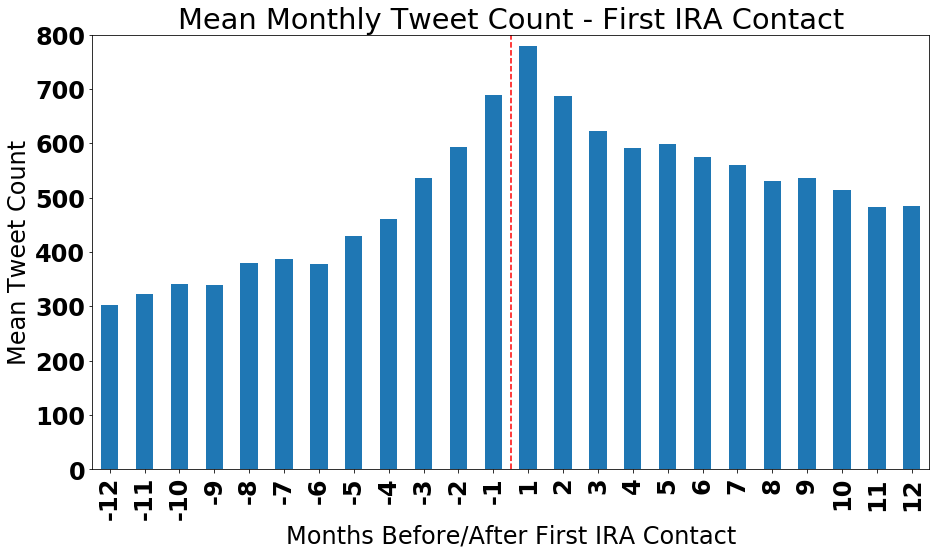

In [59]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year1DF_count.mean().plot(kind='bar', figsize=(15,8),
                            title='Mean Monthly Tweet Count - First IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.axvline(11.5, color="red", linestyle="--")
plt.ylim(top=800)
plt.ylabel('Mean Tweet Count')
plt.xlabel('Months Before/After First IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAfmean1_withresponse.png')
# plt.savefig('BefAfmean1_noresponse.png')
plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


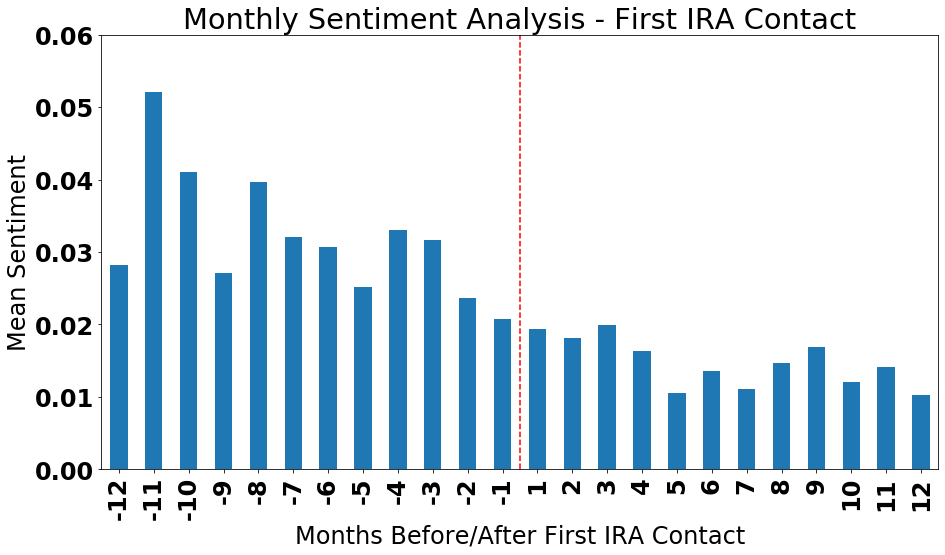

In [36]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year1DF_sent.mean().plot(kind='bar', figsize=(15,8),
                            title='Monthly Sentiment Analysis - First IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.ylim(top=0.06)
plt.ylabel('Mean Sentiment')
plt.xlabel('Months Before/After First IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAfsent1_withresponse.png')
# plt.savefig('BefAfsent1_noresponse.png')
plt.show()

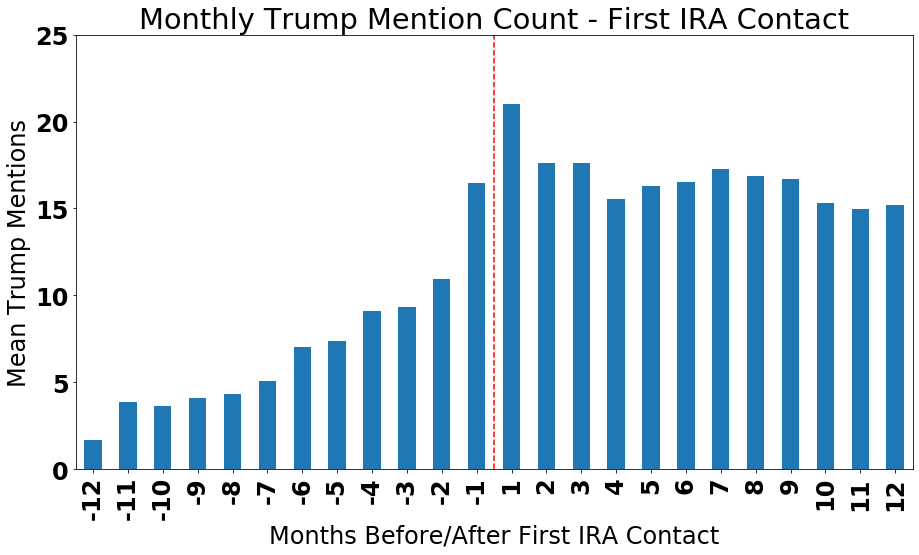

In [37]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year1DF_trump.mean().plot(kind='bar', figsize=(15,8),
                            title='Monthly Trump Mention Count - First IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.ylim(top=25)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.axvline(11.5, color="red", linestyle="--")
plt.ylabel('Mean Trump Mentions')
plt.xlabel('Months Before/After First IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAftrump1_withresponse.png')
# plt.savefig('BefAftrump1_noresponse.png')
plt.show()

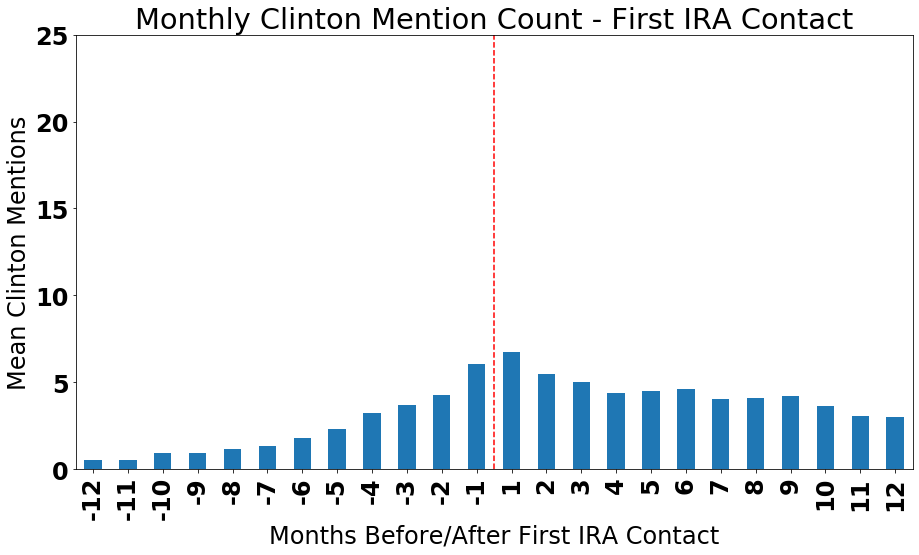

In [38]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year1DF_clinton.mean().plot(kind='bar', figsize=(15,8),
                            title='Monthly Clinton Mention Count - First IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylim(top=25)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.ylabel('Mean Clinton Mentions')
plt.xlabel('Months Before/After First IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAfclinton1_withresponse.png')
# plt.savefig('BefAfclinton1_noresponse.png')
plt.show()

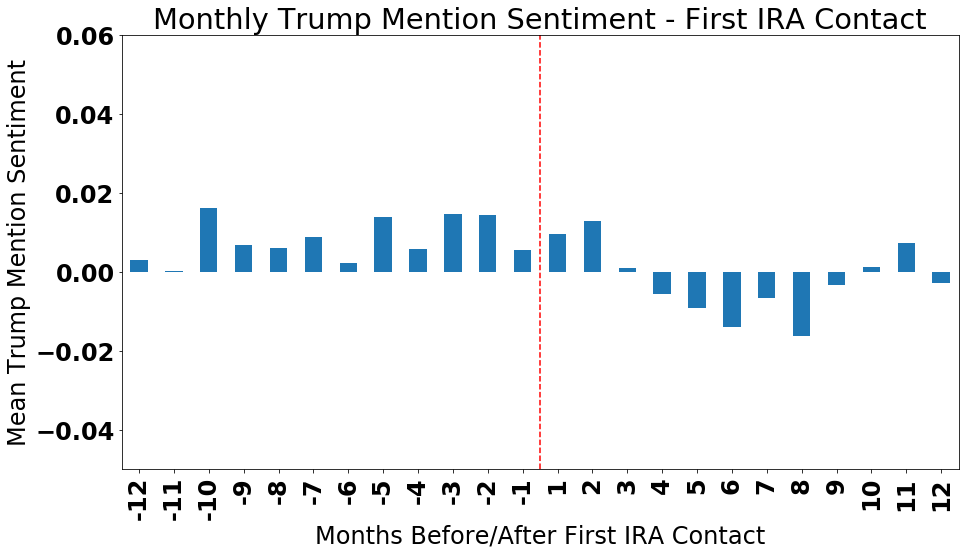

In [39]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year1DF_trump_sent.mean().plot(kind='bar', figsize=(15,8),
                            title='Monthly Trump Mention Sentiment - First IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylim(top=.06, bottom=-.05)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 26}
plt.rc('font', **font)
plt.ylabel('Mean Trump Mention Sentiment')
plt.xlabel('Months Before/After First IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAftrump_sent1_withresponse.png')
# plt.savefig('BefAftrump1_noresponse.png')
plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


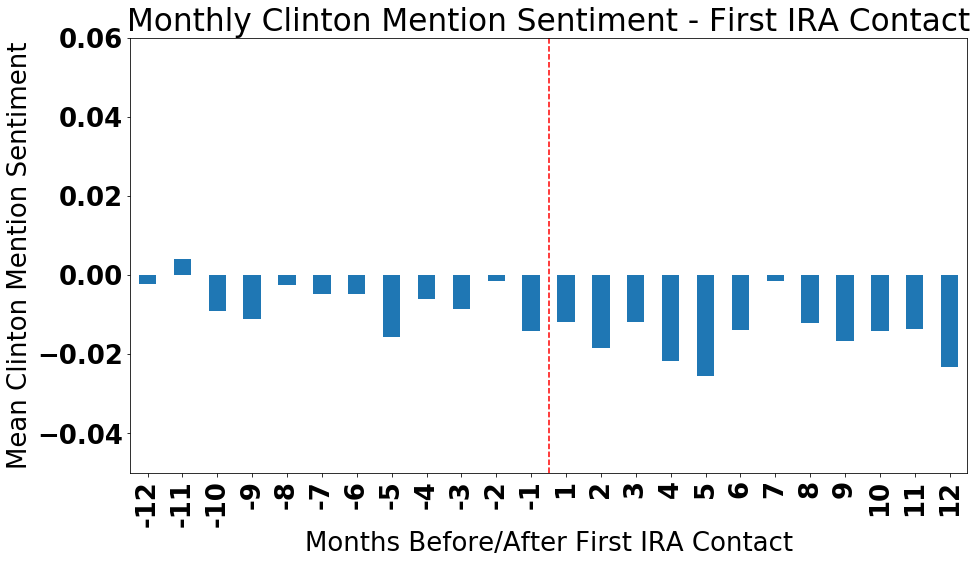

In [40]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year1DF_clinton_sent.mean().plot(kind='bar', figsize=(15,8),
                            title='Monthly Clinton Mention Sentiment - First IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
# plt.ylim(top=25)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.axvline(11.5, color="red", linestyle="--")
plt.ylim(top=.06, bottom=-.05)
plt.ylabel('Mean Clinton Mention Sentiment')
plt.xlabel('Months Before/After First IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAfclinton_sent1_withresponse.png')
# plt.savefig('BefAftrump1_noresponse.png')
plt.show()

**Contact Point Two Plots**

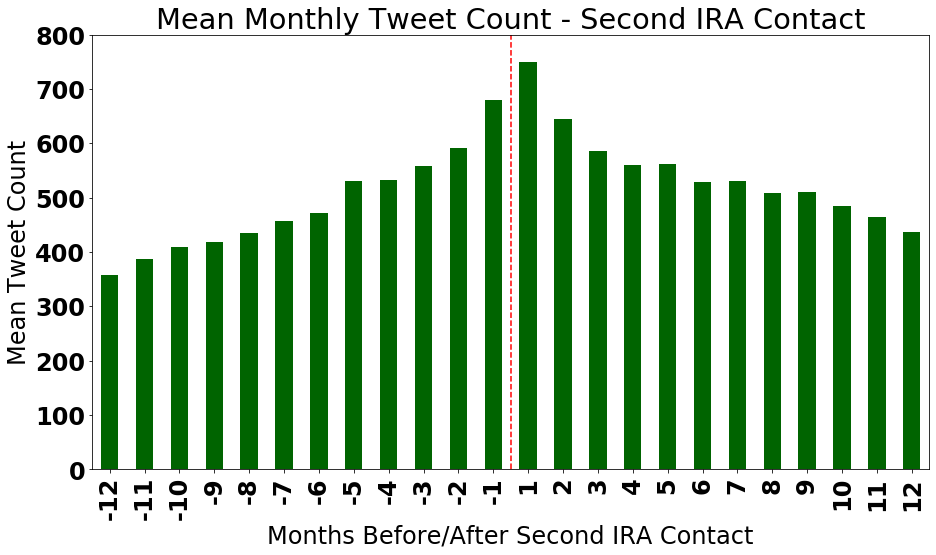

In [41]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year2DF_count.mean().plot(kind='bar', figsize=(15,8), color = 'darkgreen',
                            title='Mean Monthly Tweet Count - Second IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylim(top=800)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.ylabel('Mean Tweet Count')
plt.xlabel('Months Before/After Second IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAfmean2_withresponse.png')
# plt.savefig('BefAfmean2_noresponse.png')
plt.show()

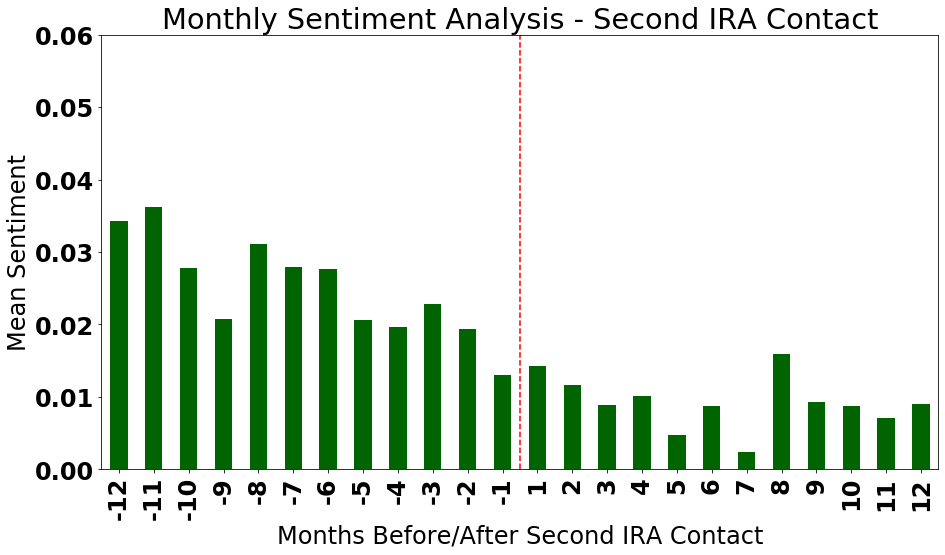

In [42]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year2DF_sent.mean().plot(kind='bar', figsize=(15,8), color ='darkgreen',
                            title='Monthly Sentiment Analysis - Second IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylim(top=0.06)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.ylabel('Mean Sentiment')
plt.xlabel('Months Before/After Second IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAfsent2_withresponse.png')
# plt.savefig('BefAfsent2_noresponse.png')
plt.show()

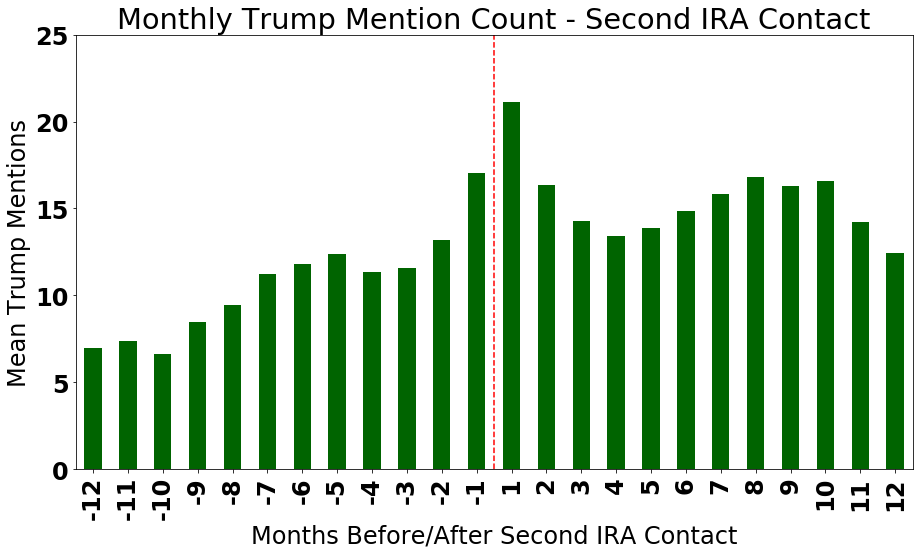

In [43]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year2DF_trump.mean().plot(kind='bar', figsize=(15,8), color='darkgreen',
                            title='Monthly Trump Mention Count - Second IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylim(top=25)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.ylabel('Mean Trump Mentions')
plt.xlabel('Months Before/After Second IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAftrump2_withresponse.png')
# plt.savefig('BefAftrump2_noresponse.png')

plt.show()

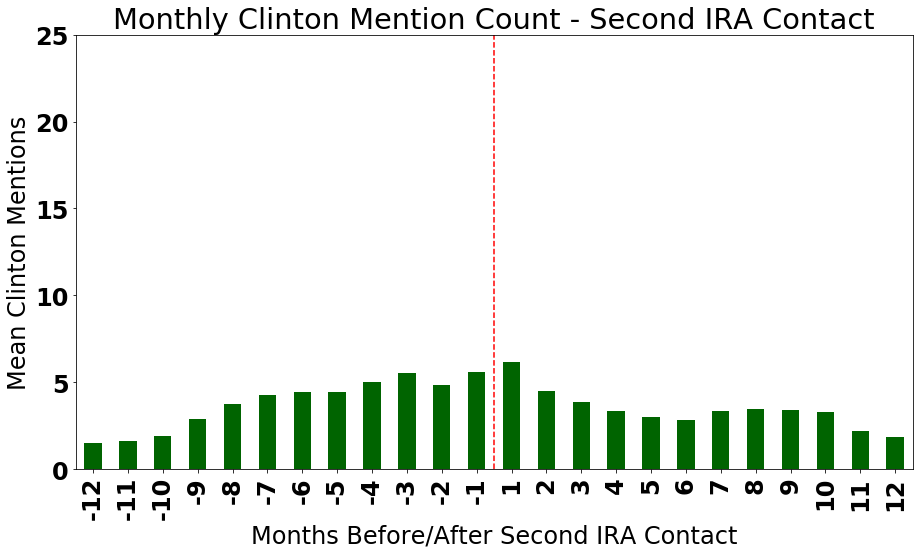

In [44]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year2DF_clinton.mean().plot(kind='bar', figsize=(15,8), color='darkgreen',
                            title='Monthly Clinton Mention Count - Second IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylim(top=25)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.ylabel('Mean Clinton Mentions')
plt.xlabel('Months Before/After Second IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAfclinton2_withresponse.png')
# plt.savefig('BefAfclinton2_noresponse.png')

plt.show()

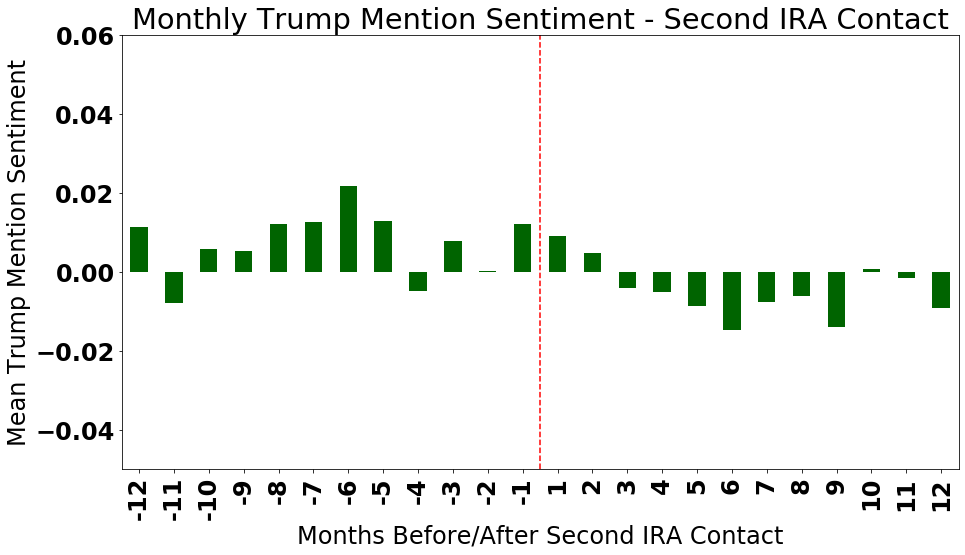

In [45]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year2DF_trump_sent.mean().plot(kind='bar', figsize=(15,8), color='darkgreen',
                            title='Monthly Trump Mention Sentiment - Second IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
# plt.ylim(top=25)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.ylim(top=.06, bottom=-.05)
plt.ylabel('Mean Trump Mention Sentiment')
plt.xlabel('Months Before/After Second IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAftrump_sent2_withresponse.png')
# plt.savefig('BefAftrump2_noresponse.png')
plt.show()

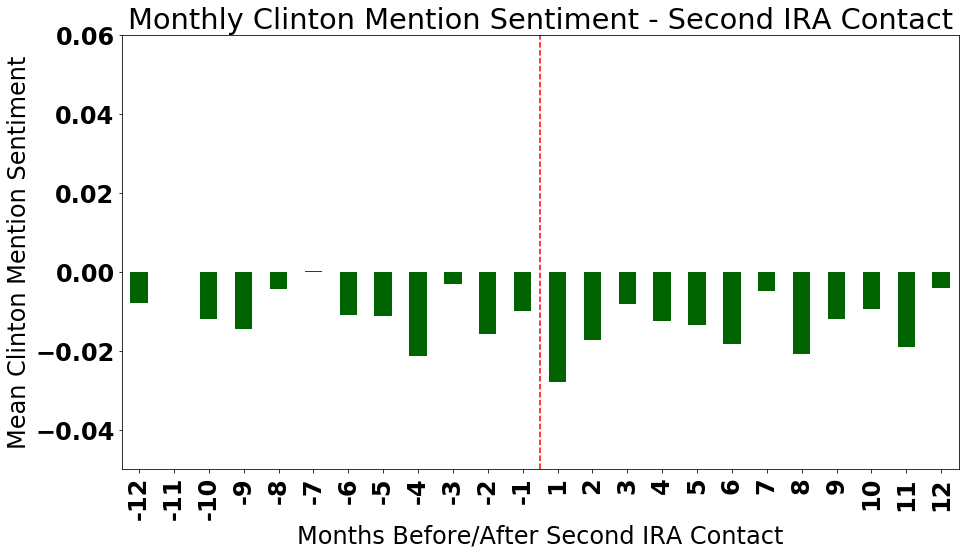

In [46]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year2DF_clinton_sent.mean().plot(kind='bar', figsize=(15,8), color='darkgreen',
                            title='Monthly Clinton Mention Sentiment - Second IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
# plt.ylim(top=25)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.ylim(top=.06, bottom=-.05)
plt.ylabel('Mean Clinton Mention Sentiment')
plt.xlabel('Months Before/After Second IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAfclinton_sent2_withresponse.png')
# plt.savefig('BefAftrump2_noresponse.png')
plt.show()

**Contact Point Three Plots**

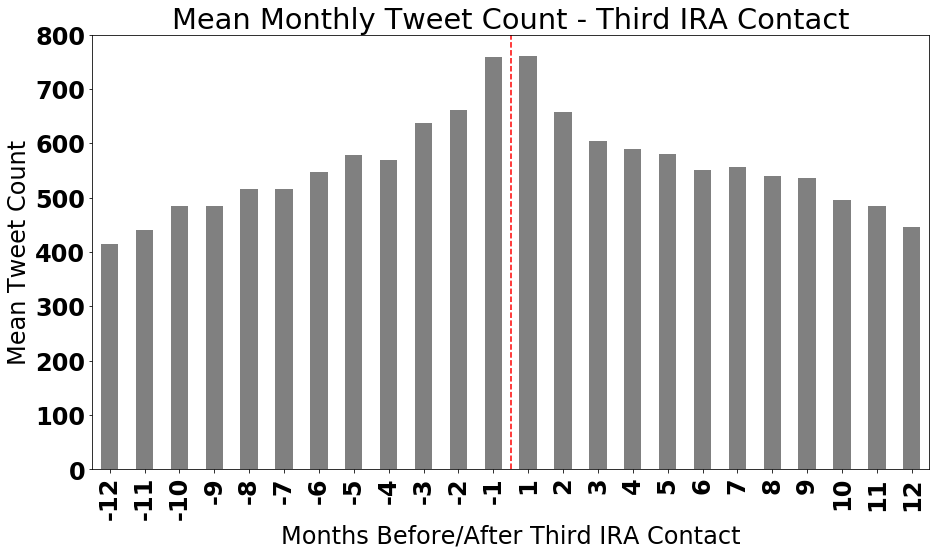

In [47]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year3DF_count.mean().plot(kind='bar', figsize=(15,8), color = 'grey',
                            title='Mean Monthly Tweet Count - Third IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylim(top=800)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.ylabel('Mean Tweet Count')
plt.xlabel('Months Before/After Third IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAfmean3_withresponse.png')
# plt.savefig('BefAfmean3_noresponse.png')

plt.show()

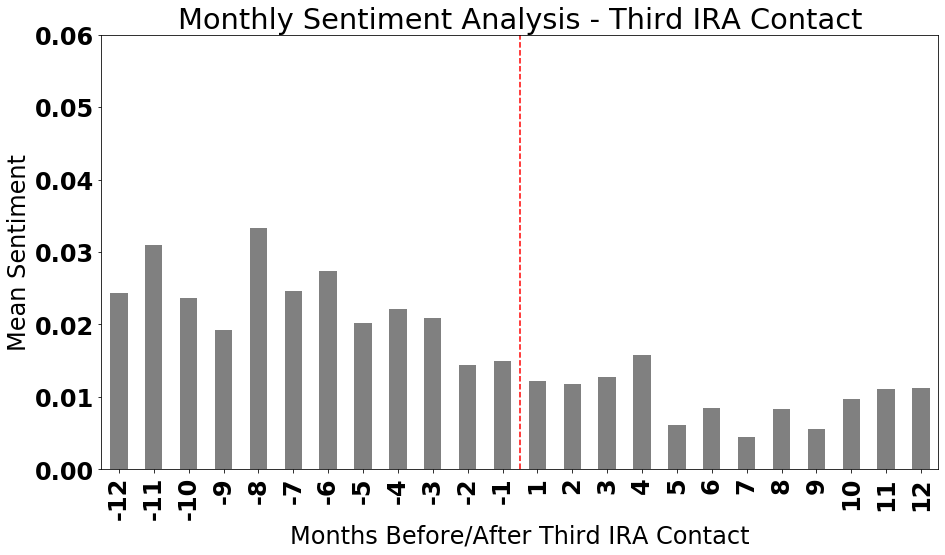

In [48]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year3DF_sent.mean().plot(kind='bar', figsize=(15,8), color ='grey',
                            title='Monthly Sentiment Analysis - Third IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.ylim(top=0.06)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.axvline(11.5, color="red", linestyle="--")
plt.ylabel('Mean Sentiment')
plt.xlabel('Months Before/After Third IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAfsent3_withresponse.png')
# plt.savefig('BefAfsent3_noresponse.png')

plt.show()

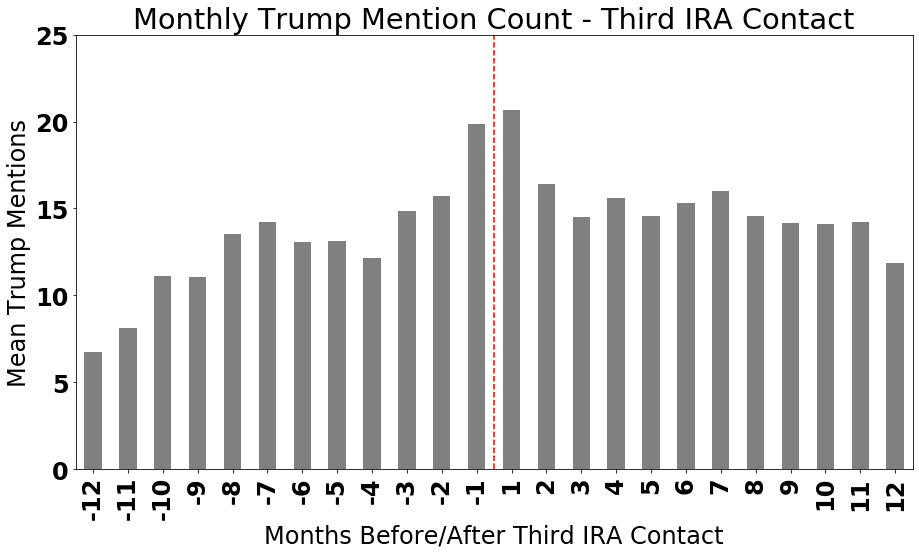

In [49]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year3DF_trump.mean().plot(kind='bar', figsize=(15,8), color='grey',
                            title='Monthly Trump Mention Count - Third IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylim(top=25)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.ylabel('Mean Trump Mentions')
plt.xlabel('Months Before/After Third IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAftrump3_withresponse.png')
# plt.savefig('BefAftrump3_noresponse.png')

plt.show()

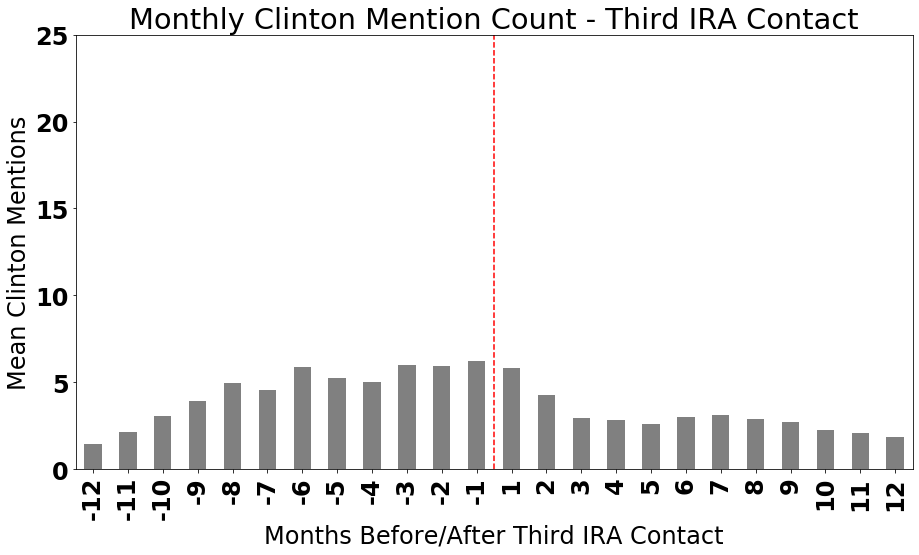

In [50]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year3DF_clinton.mean().plot(kind='bar', figsize=(15,8), color='grey',
                            title='Monthly Clinton Mention Count - Third IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.ylim(top=25)
plt.ylabel('Mean Clinton Mentions')
plt.xlabel('Months Before/After Third IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAfclinton3_withresponse.png')
# plt.savefig('BefAfclinton3_noresponse.png')

plt.show()

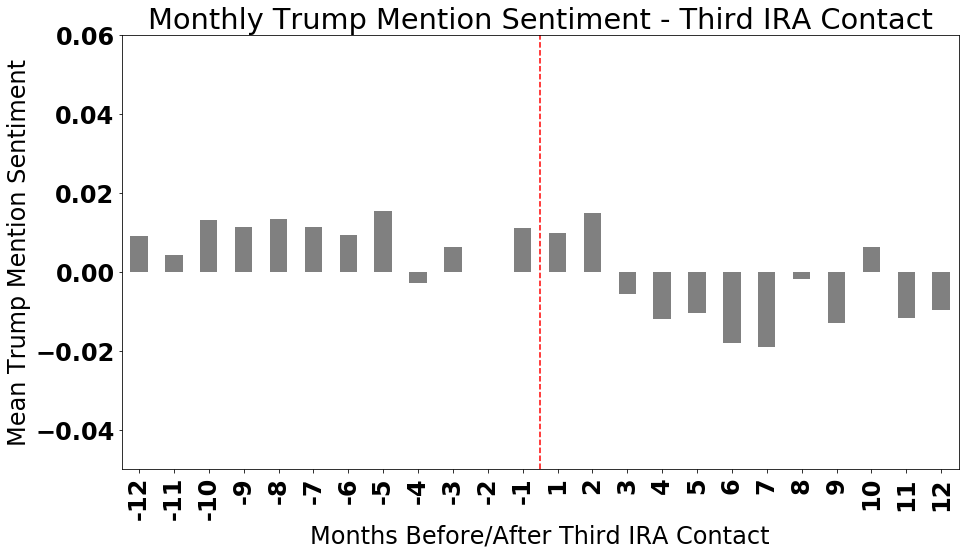

In [51]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year3DF_trump_sent.mean().plot(kind='bar', figsize=(15,8), color='grey',
                            title='Monthly Trump Mention Sentiment - Third IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
# plt.ylim(top=25)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.ylim(top=.06, bottom=-.05)
plt.ylabel('Mean Trump Mention Sentiment')
plt.xlabel('Months Before/After Third IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAftrump_sent3_withresponse.png')
# plt.savefig('BefAftrump3_noresponse.png')

plt.show()

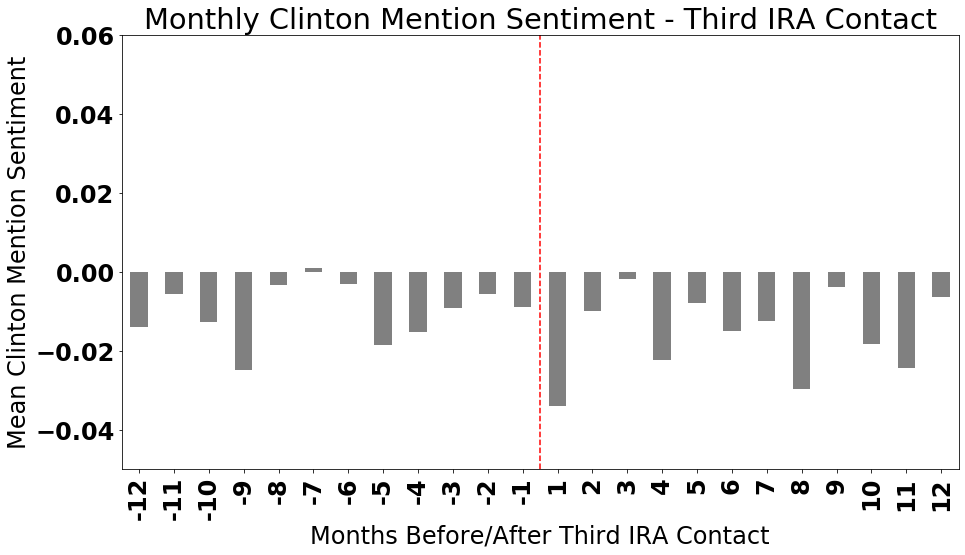

In [52]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year3DF_clinton_sent.mean().plot(kind='bar', figsize=(15,8), color='grey',
                            title='Monthly Clinton Mention Sentiment - Third IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
# plt.ylim(top=25)
plt.ylim(top=.06, bottom=-.05)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.ylabel('Mean Clinton Mention Sentiment')
plt.xlabel('Months Before/After Third IRA Contact')
plt.savefig('BefAft_V3_DidRespond/BefAfclinton_sent3_withresponse.png')
# plt.savefig('BefAftrump3_noresponse.png')

plt.show()

In [53]:
# beforeAfterDF.head()
# befAftCounts.head()

In [54]:
# count = 0
# remove_users = []
# for i in range(len(beforeAfterDF)):
# # for i in range(10):
#     first_contact = beforeAfterDF['first_contact'][i]
#     first_tweety = dt.strptime(first_tweet_dict[beforeAfterDF['username'][i]], "%Y-%m-%d")
#     if first_tweety >= first_contact:
#         remove_users.append(beforeAfterDF['username'][i])
# #         print(beforeAfterDF['username'][i])
# #         print(first_tweety)
# #         print(first_contact)
#         count += 1
# print(count)
    

In [55]:
# removeDF = pd.DataFrame(remove_users)

In [56]:
# removeDF.columns = ['username']

In [57]:
# removeDF.head()

In [58]:
# removeDF.to_csv('removeUsers_DidNotMentionBackUsers.csv')